## Embed CSV Files with Google Gemini

https://python.langchain.com/docs/integrations/text_embedding/google_generative_ai/

https://github.com/mongodb-developer/GenAI-Showcase/blob/50535ba52c872ed03a975bf180f01f84696e7cc9/notebooks/agents/agentic_rag_factory_safety_assistant_with_langgraph_langchain_mongodb.ipynb

# Google Generative AI Embeddings (AI Studio & Gemini API)

Connect to Google's generative AI embeddings service using the `GoogleGenerativeAIEmbeddings` class, found in the [langchain-google-genai](https://pypi.org/project/langchain-google-genai/) package.

This will help you get started with Google's Generative AI embedding models (like Gemini) using LangChain. For detailed documentation on `GoogleGenerativeAIEmbeddings` features and configuration options, please refer to the [API reference](https://python.langchain.com/v0.2/api_reference/google_genai/embeddings/langchain_google_genai.embeddings.GoogleGenerativeAIEmbeddings.html).

## Overview
### Integration details

import { ItemTable } from "@theme/FeatureTables";

<ItemTable category="text_embedding" item="Google Gemini" />

## Setup

To access Google Generative AI embedding models you'll need to create a Google Cloud project, enable the Generative Language API, get an API key, and install the `langchain-google-genai` integration package.

### Credentials

To use Google Generative AI models, you must have an API key. You can create one in Google AI Studio. See the [Google documentation](https://ai.google.dev/gemini-api/docs/api-key) for instructions.

Once you have a key, set it as an environment variable `GOOGLE_API_KEY`:


In [1]:
import getpass
import os

#if not os.getenv("GOOGLE_API_KEY"):
#    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google API key: ")

In [2]:
from dotenv import load_dotenv
import os

In [3]:
load_dotenv()  # This loads variables from .env into the environment


True

In [4]:
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

In [5]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

## Installation

In [6]:
#%pip uninstall -y google-generativeai google-ai-generativelanguage==0.6.18


In [7]:
#%pip install google-generativeai==0.3.2 google-ai-generativelanguage==0.4.0

In [8]:
#%pip install --upgrade --quiet  langchain-google-genai

In [9]:
import pandas as pd

In [10]:
GEMINI_EMBEDDING_MODEL = "models/embedding-001"#"models/gemini-embedding-exp-03-07"

In [11]:
#!pip list

In [12]:
#from google.generativeai import GenerativeModel
#GEMINI_EMBEDDING_MODEL = "models/embedding-001"#"models/gemini-embedding-exp-03-07"
#embedding_model = GenerativeModel(model_name=GEMINI_EMBEDDING_MODEL)

In [13]:

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embedding_model = GoogleGenerativeAIEmbeddings(
    model=GEMINI_EMBEDDING_MODEL,
    task_type="RETRIEVAL_DOCUMENT"
)

In [14]:
from google.generativeai import GenerativeModel

In [15]:
embedding_model = GenerativeModel(model_name=GEMINI_EMBEDDING_MODEL)

In [16]:
import sys

In [17]:
# Add the root directory of your project to Python path
project_root = os.path.abspath("../backend")
if project_root not in sys.path:
    sys.path.append(project_root)

## Connect to the MongoDB collection

In [18]:
from db.mongodb_client import mongodb_client

✅ MongoDB connection established.


In [19]:
# Names of the MongoDB database, collection and vector search index
DB_NAME = "diabetes_data"
COLLECTION_NAME = "records_embeddings"
VS_INDEX_NAME = "csv_vector_index"

In [20]:
db = mongodb_client[DB_NAME]

In [21]:
# Connect to the MongoDB collection
collection = mongodb_client[DB_NAME][COLLECTION_NAME]

In [19]:

print("Client:", mongodb_client)
print("Databases:", mongodb_client.list_database_names())

Client: MongoClient(host=['ac-t38w2lp-shard-00-02.q4fmjuw.mongodb.net:27017', 'ac-t38w2lp-shard-00-01.q4fmjuw.mongodb.net:27017', 'ac-t38w2lp-shard-00-00.q4fmjuw.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', appname='Search4Cure.diabetes', authsource='admin', replicaset='atlas-lunm1g-shard-0', tls=True, server_api=<pymongo.server_api.ServerApi object at 0x16ba93c50>)
Databases: ['diabetes_data', 'admin', 'local']


## Google Cloud Credentials

In [22]:
path_to_credentials = ""

In [23]:
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = path_to_credentials


## Insert to MongoDB

In [16]:
import numpy as np


def combine_all_attributes(df, exclude_columns=None):
    """
    Combine all attributes (optionally excluding some) of a DataFrame row into a single column.

    Parameters:
    - df: pandas DataFrame
    - exclude_columns: list of column names to exclude from the combination

    Returns:
    - df: DataFrame with a new 'combined_info' column
    """
    exclude_columns = exclude_columns or []

    def combine_row(row):
        combined = []
        for attr in row.index:
            if attr in exclude_columns:
                continue
            value = row[attr]
            if isinstance(value, (pd.Series, np.ndarray, list)):
                # Handle array-like objects
                if len(value) > 0 and not pd.isna(value).all():
                    combined.append(f"{attr.capitalize()}: {value!s}")
            elif not pd.isna(value):
                combined.append(f"{attr.capitalize()}: {value!s}")
        return " ".join(combined)

    df["combined_info"] = df.apply(combine_row, axis=1)
    return df

In [24]:
from tqdm import tqdm
from datetime import datetime

In [25]:
import itertools

In [ ]:

 # === Local Files Folder ===
LOCAL_FOLDER = "../data/data_new" 

for file_name in os.listdir(LOCAL_FOLDER):
    file_path = os.path.join(LOCAL_FOLDER, file_name)

    # Skip non-data files
    if not file_name.lower().endswith(('.csv', '.xlsx', '.xls', '.json')):
        print(f"Skipping unsupported file: {file_name}")
        continue
    
    datasets_col = db["datasets"]
    data_col = db["records_embeddings"]

    #Check if file already uploaded
    existing = datasets_col.find_one({"file_name": file_name})
    if existing:
         print(f"⏭️ Skipping {file_name} (already uploaded)")
         #continue

    print(f"📂 Processing {file_name}...")
    # Initialize metadata tracking
    first_chunk = None
    total_rows = 0
    combined_missing = None

    # Read file into DataFrame
    try:
        if file_name.endswith(".csv"):
            chunk_iter = pd.read_csv(file_path, chunksize=500)
        elif file_name.endswith((".xlsx", ".xls")):
            chunk_iter = pd.read_excel(file_path, chunksize=500)
        elif file_name.endswith(".json"):
            chunk_iter = pd.read_json(file_path, lines=True, chunksize=500)
    except Exception as e:
        print(f"❌ Failed to read {file_name}: {e}")
        continue
    dataset_id = None

    # === Insert Metadata ===
    start_index = 1500

    # Skip the first `start_index // chunksize` chunks
    chunks_to_embed = itertools.islice(chunk_iter, start_index // 500, None)
    #for chunk_idx, chunk in enumerate(chunk_iter):
    # Now embed starting from chunk N
    for chunk_idx, chunk in enumerate(tqdm(chunks_to_embed, desc="Embedding", initial=start_index, total=None)):       
        if first_chunk is None:
            first_chunk = chunk.copy()
            combined_missing = chunk.isnull().sum()
            dataset_doc = {
                "file_name": file_name,
                "upload_date": datetime.now(),
                "n_columns": chunk.shape[1],
                "columns": chunk.columns.tolist(),
                "missing_values": chunk.isnull().sum().to_dict(),
                "file_type": os.path.splitext(file_name)[-1].replace(".", ""),
                "file_path": file_path,
                "column_types": chunk.dtypes.astype(str).to_dict(),
            }
            dataset_id = datasets_col.insert_one(dataset_doc).inserted_id
            print(f"✅ Inserted metadata for {file_name}")

        total_rows += len(chunk)
    
        # === Combine all attributes ===
        chunk = combine_all_attributes(chunk, exclude_columns=[])
        print(chunk[["combined_info"]].head(2))  # preview
    
        duplicated_data = []
        for row in tqdm(chunk.itertuples(index=False), total=len(chunk), desc="Embedding"):
            duplicated_rows = get_embedding(row._asdict())
            duplicated_data.extend(duplicated_rows)

        if duplicated_data:
            df_dup = pd.DataFrame(duplicated_data)
            print(df_dup.head(2))
            try:
                total_inserted_tabular = insert_df_to_mongodb(df_dup, data_col, dataset_id)
                print(
                    f"📌 Chunk {chunk_idx + 1}: {len(df_dup)} documents inserted."
                )
            except Exception as e:
                print(f"❌ Error inserting chunk {chunk_idx + 1}: {e}")

    if dataset_id:
        datasets_col.update_one(
            {"_id": dataset_id},
            {"$set": {"n_rows": total_rows}}
        )
        print(f"✅ Finalized metadata for {file_name}: {total_rows} rows")

    # # Combine all columns into 'combined_info'
    # df = combine_all_attributes(df, exclude_columns=[])  
    # print(df[["combined_info"]].head(2))  # preview

    # # Apply the function and expand the dataset
    # duplicated_data = []
    # for _, row in tqdm(
    #     df.iterrows(),
    #     desc="Generating embeddings and duplicating rows",
    #     total=len(df),
    # ):
    #     duplicated_rows = get_embedding(row)
    #     duplicated_data.extend(duplicated_rows)

    # # Create a new DataFrame from the duplicated data
    # df = pd.DataFrame(duplicated_data)
    #print(df.head(2))

    # === Insert Data Records ===
    # Insert dataframe to mongodb
    # try:
    #     total_inserted_tabular = insert_df_to_mongodb(df, data_col, dataset_id)
    #     print(
    #         f"{file_name} data ingestion completed. Total documents inserted: {total_inserted_tabular}"
    #     )
    # except Exception as e:
    #     print(f"An error occurred while inserting {file_name}: {e}")
    #     print("Pandas version:", pd.__version__)
    # print_dataframe_info(df, {file_name})

# Final summary
print(f"\n✅ Ingestion process completed for all {total_inserted_tabular} files.")
# print("\nInsertion Summary:")
# print(
#     f"Tabular files inserted: {total_inserted_tabular if 'total_inserted_tabular' in locals() else 'Failed'}"
# )


     
        
    # data_records = df.to_dict(orient="records")
    # for record in data_records:
    #     record["dataset_id"] = dataset_id

    # if data_records:
    #     data_col.insert_many(data_records)
    #     print(f"✅ Uploaded data records for {file_name}")

In [69]:

 
for file_name in os.listdir(LOCAL_FOLDER):
    file_path = os.path.join(LOCAL_FOLDER, file_name)

    # Skip non-data files
    if not file_name.lower().endswith(('.csv', '.xlsx', '.xls', '.json')):
        print(f"Skipping unsupported file: {file_name}")
        continue
    
    datasets_col = db["datasets"]
    data_col = db["records_embeddings"]

    #Check if file already uploaded
    existing = datasets_col.find_one({"file_name": file_name})
    if existing:
         print(f"⏭️ Skipping {file_name} (already uploaded)")
         #continue

    print(f"📂 Processing {file_name}...")
    # Initialize metadata tracking
    first_chunk = None
    total_rows = 0
    combined_missing = None

    # Read file into DataFrame
    try:
        if file_name.endswith(".csv"):
            chunk_iter = pd.read_csv(file_path, chunksize=500)
        elif file_name.endswith((".xlsx", ".xls")):
            chunk_iter = pd.read_excel(file_path, chunksize=500)
        elif file_name.endswith(".json"):
            chunk_iter = pd.read_json(file_path, lines=True, chunksize=500)
    except Exception as e:
        print(f"❌ Failed to read {file_name}: {e}")
        continue
    dataset_id = None

    # === Insert Metadata ===
    start_index = 1500

    # Skip the first `start_index // chunksize` chunks
    chunks_to_embed = itertools.islice(chunk_iter, start_index // 500, None)
    #for chunk_idx, chunk in enumerate(chunk_iter):
    # Now embed starting from chunk N
    for chunk_idx, chunk in enumerate(tqdm(chunks_to_embed, desc="Embedding", initial=start_index, total=None)):       
        if first_chunk is None:
            first_chunk = chunk.copy()
            combined_missing = chunk.isnull().sum()
            dataset_doc = {
                "file_name": file_name,
                "upload_date": datetime.now(),
                "n_columns": chunk.shape[1],
                "columns": chunk.columns.tolist(),
                "missing_values": chunk.isnull().sum().to_dict(),
                "file_type": os.path.splitext(file_name)[-1].replace(".", ""),
                "file_path": file_path,
                "column_types": chunk.dtypes.astype(str).to_dict(),
            }
            dataset_id = datasets_col.insert_one(dataset_doc).inserted_id
            print(f"✅ Inserted metadata for {file_name}")

        total_rows += len(chunk)
    
        # === Combine all attributes ===
        chunk = combine_all_attributes(chunk, exclude_columns=[])
        print(chunk[["combined_info"]].head(2))  # preview
    
        duplicated_data = []
        for row in tqdm(chunk.itertuples(index=False), total=len(chunk), desc="Embedding"):
            duplicated_rows = get_embedding(row._asdict())
            duplicated_data.extend(duplicated_rows)

        if duplicated_data:
            df_dup = pd.DataFrame(duplicated_data)
            print(df_dup.head(2))
            try:
                total_inserted_tabular = insert_df_to_mongodb(df_dup, data_col, dataset_id)
                print(
                    f"📌 Chunk {chunk_idx + 1}: {len(df_dup)} documents inserted."
                )
            except Exception as e:
                print(f"❌ Error inserting chunk {chunk_idx + 1}: {e}")

    if dataset_id:
        datasets_col.update_one(
            {"_id": dataset_id},
            {"$set": {"n_rows": total_rows}}
        )
        print(f"✅ Finalized metadata for {file_name}: {total_rows} rows")

    # # Combine all columns into 'combined_info'
    # df = combine_all_attributes(df, exclude_columns=[])  
    # print(df[["combined_info"]].head(2))  # preview

    # # Apply the function and expand the dataset
    # duplicated_data = []
    # for _, row in tqdm(
    #     df.iterrows(),
    #     desc="Generating embeddings and duplicating rows",
    #     total=len(df),
    # ):
    #     duplicated_rows = get_embedding(row)
    #     duplicated_data.extend(duplicated_rows)

    # # Create a new DataFrame from the duplicated data
    # df = pd.DataFrame(duplicated_data)
    #print(df.head(2))

    # === Insert Data Records ===
    # Insert dataframe to mongodb
    # try:
    #     total_inserted_tabular = insert_df_to_mongodb(df, data_col, dataset_id)
    #     print(
    #         f"{file_name} data ingestion completed. Total documents inserted: {total_inserted_tabular}"
    #     )
    # except Exception as e:
    #     print(f"An error occurred while inserting {file_name}: {e}")
    #     print("Pandas version:", pd.__version__)
    # print_dataframe_info(df, {file_name})

# Final summary
print(f"\n✅ Ingestion process completed for all {total_inserted_tabular} files.")
# print("\nInsertion Summary:")
# print(
#     f"Tabular files inserted: {total_inserted_tabular if 'total_inserted_tabular' in locals() else 'Failed'}"
# )


     
        
    # data_records = df.to_dict(orient="records")
    # for record in data_records:
    #     record["dataset_id"] = dataset_id

    # if data_records:
    #     data_col.insert_many(data_records)
    #     print(f"✅ Uploaded data records for {file_name}")

Skipping unsupported file: .DS_Store
⏭️ Skipping diabetic_data.csv (already uploaded)
📂 Processing diabetic_data.csv...
✅ Inserted metadata for diabetic_data.csv
                                       combined_info
0  Encounter_id: 2278392 Patient_nbr: 8222157 Rac...
1  Encounter_id: 149190 Patient_nbr: 55629189 Rac...


Embedding: 100%|██████████| 500/500 [39:38<00:00,  4.76s/it]    


   encounter_id  patient_nbr       race  gender      age weight  \
0       2278392      8222157  Caucasian  Female   [0-10)      ?   
1        149190     55629189  Caucasian  Female  [10-20)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   

   time_in_hospital  ... _42 _43  _44  _45  _46  change  diabetesMed  \
0                 1  ...  No  No   No   No   No      No           No   
1                 3  ...  No  No   No   No   No      Ch          Yes   

   readmitted                                      combined_info  \
0          NO  Encounter_id: 2278392 Patient_nbr: 8222157 Rac...   
1         >30  Encounter_id: 149190 Patient_nbr: 55629189 Rac...   

                                           embedding  
0  [0.019425964, -0.0024473513, -0.09022015, -0.0...  
1  [0.019444333, -0.004087155, -0.07224274, 3.688...

Embedding: 100%|██████████| 500/500 [19:05<00:00,  2.29s/it]  


   encounter_id  patient_nbr             race  gender      age weight  \
0       4255176      2139525        Caucasian  Female  [60-70)      ?   
1       4255452     99109602  AfricanAmerican  Female  [60-70)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    7   
1                  1                         6                    7   

   time_in_hospital  ... _42 _43  _44  _45  _46  change  diabetesMed  \
0                10  ...  No  No   No   No   No      No          Yes   
1                10  ...  No  No   No   No   No      No           No   

   readmitted                                      combined_info  \
0          NO  Encounter_id: 4255176 Patient_nbr: 2139525 Rac...   
1          NO  Encounter_id: 4255452 Patient_nbr: 99109602 Ra...   

                                           embedding  
0  [0.022118663, 0.0037105205, -0.07894335, -0.00...  
1  [0.020221915, 0.0010955177, -0.

Embedding: 100%|██████████| 500/500 [16:35<00:00,  1.99s/it]  


   encounter_id  patient_nbr       race gender      age weight  \
0       7556418      4282317  Caucasian   Male  [50-60)      ?   
1       7564920        94527  Caucasian   Male  [70-80)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  1                         1                    7   
1                  1                         1                    7   

   time_in_hospital  ... _42 _43  _44  _45  _46  change  diabetesMed  \
0                 6  ...  No  No   No   No   No      No          Yes   
1                 2  ...  No  No   No   No   No      No          Yes   

   readmitted                                      combined_info  \
0          NO  Encounter_id: 7556418 Patient_nbr: 4282317 Rac...   
1         >30  Encounter_id: 7564920 Patient_nbr: 94527 Race:...   

                                           embedding  
0  [0.018956222, 0.002368126, -0.0839956, -0.0046...  
1  [0.019801792, 0.0050626164, -0.075723045, 0.00...  


Embedding:  86%|████████▌ | 429/500 [2:08:11<21:12, 17.93s/it]    


DeadlineExceeded: 504 Deadline Exceeded

In [77]:

# === Local Files Folde7r ===
LOCAL_FOLDER = "../data/data_new2" 
for file_name in os.listdir(LOCAL_FOLDER):
    file_path = os.path.join(LOCAL_FOLDER, file_name)

    # Skip non-data files
    if not file_name.lower().endswith(('.csv', '.xlsx', '.xls', '.json')):
        print(f"Skipping unsupported file: {file_name}")
        continue
    
    datasets_col = db["datasets"]
    data_col = db["records_embeddings"]

    #Check if file already uploaded
    existing = datasets_col.find_one({"file_name": file_name})
    if existing:
         print(f"⏭️ Skipping {file_name} (already uploaded)")
         #continue

    print(f"📂 Processing {file_name}...")
    # Initialize metadata tracking
    first_chunk = None
    total_rows = 0
    combined_missing = None

    # Read file into DataFrame
    try:
        if file_name.endswith(".csv"):
            chunk_iter = pd.read_csv(file_path, chunksize=500)
        elif file_name.endswith((".xlsx", ".xls")):
            chunk_iter = pd.read_excel(file_path, n_rows=500)
        elif file_name.endswith(".json"):
            chunk_iter = pd.read_json(file_path, lines=True, chunksize=500)
    except Exception as e:
        print(f"❌ Failed to read {file_name}: {e}")
        continue
    dataset_id = None

    # === Insert Metadata ===
    start_index = 1000

    # Skip the first `start_index // chunksize` chunks
    #chunks_to_embed = itertools.islice(chunk_iter, start_index // 500, None)
    
    # Now embed starting from chunk N
    #for chunk_idx, chunk in enumerate(tqdm(chunks_to_embed, desc="Embedding", initial=start_index, total=None)):    
    for chunk_idx, chunk in enumerate(chunk_iter):
        if first_chunk is None:
            first_chunk = chunk.copy()
            combined_missing = chunk.isnull().sum()
            dataset_doc = {
                "file_name": file_name,
                "upload_date": datetime.now(),
                "n_columns": chunk.shape[1],
                "columns": chunk.columns.tolist(),
                "missing_values": chunk.isnull().sum().to_dict(),
                "file_type": os.path.splitext(file_name)[-1].replace(".", ""),
                "file_path": file_path,
                "column_types": chunk.dtypes.astype(str).to_dict(),
            }
            dataset_id = datasets_col.insert_one(dataset_doc).inserted_id
            print(f"✅ Inserted metadata for {file_name}")

        total_rows += len(chunk)
    
        # === Combine all attributes ===
        chunk = combine_all_attributes(chunk, exclude_columns=[])
        print(chunk[["combined_info"]].head(2))  # preview
    
        duplicated_data = []
        for row in tqdm(chunk.itertuples(index=False), total=len(chunk), desc="Embedding"):
            duplicated_rows = get_embedding(row._asdict())
            duplicated_data.extend(duplicated_rows)

        if duplicated_data:
            df_dup = pd.DataFrame(duplicated_data)
            print(df_dup.head(2))
            try:
                total_inserted_tabular = insert_df_to_mongodb(df_dup, data_col, dataset_id)
                print(
                    f"📌 Chunk {chunk_idx + 1}: {len(df_dup)} documents inserted."
                )
            except Exception as e:
                print(f"❌ Error inserting chunk {chunk_idx + 1}: {e}")

    if dataset_id:
        datasets_col.update_one(
            {"_id": dataset_id},
            {"$set": {"n_rows": total_rows}}
        )
        print(f"✅ Finalized metadata for {file_name}: {total_rows} rows")

    # # Combine all columns into 'combined_info'
    # df = combine_all_attributes(df, exclude_columns=[])  
    # print(df[["combined_info"]].head(2))  # preview

    # # Apply the function and expand the dataset
    # duplicated_data = []
    # for _, row in tqdm(
    #     df.iterrows(),
    #     desc="Generating embeddings and duplicating rows",
    #     total=len(df),
    # ):
    #     duplicated_rows = get_embedding(row)
    #     duplicated_data.extend(duplicated_rows)

    # # Create a new DataFrame from the duplicated data
    # df = pd.DataFrame(duplicated_data)
    #print(df.head(2))

    # === Insert Data Records ===
    # Insert dataframe to mongodb
    # try:
    #     total_inserted_tabular = insert_df_to_mongodb(df, data_col, dataset_id)
    #     print(
    #         f"{file_name} data ingestion completed. Total documents inserted: {total_inserted_tabular}"
    #     )
    # except Exception as e:
    #     print(f"An error occurred while inserting {file_name}: {e}")
    #     print("Pandas version:", pd.__version__)
    # print_dataframe_info(df, {file_name})

# Final summary
print(f"\n✅ Ingestion process completed for all {total_inserted_tabular} files.")
# print("\nInsertion Summary:")
# print(
#     f"Tabular files inserted: {total_inserted_tabular if 'total_inserted_tabular' in locals() else 'Failed'}"
# )


     
        
    # data_records = df.to_dict(orient="records")
    # for record in data_records:
    #     record["dataset_id"] = dataset_id

    # if data_records:
    #     data_col.insert_many(data_records)
    #     print(f"✅ Uploaded data records for {file_name}")

📂 Processing GALLSTONE_dataset-uci_2025.xlsx...
❌ Failed to read GALLSTONE_dataset-uci_2025.xlsx: read_excel() got an unexpected keyword argument 'n_rows'
⏭️ Skipping berm_hipdata.csv (already uploaded)
📂 Processing berm_hipdata.csv...
✅ Inserted metadata for berm_hipdata.csv
                                       combined_info
0  Diabetes_status: T1D Age: 41.7303217 B_cells_p...
1  Diabetes_status: T1D Age: 20.62422998 B_cells_...


Embedding: 100%|██████████| 500/500 [2:18:10<00:00, 16.58s/it]  


  Diabetes_Status        Age  B_cells_pct_of_Lymphocytes  \
0             T1D  41.730322                        5.02   
1             T1D  41.730322                        5.02   

   Transitional_pct_of_B_cells  Naive_pct_of_B_cells  \
0                         5.22                  68.3   
1                         5.22                  68.3   

   Nonnegclassnegswitched_Memory_pct_of_B_cells  \
0                                          15.7   
1                                          15.7   

   Classnegswitched_Memory_pct_of_B_cells    _7  MNC_pct_of_Leukocytes  \
0                                    10.7  0.15                   42.2   
1                                    10.7  0.15                   42.2   

   Granulocyte_pct_of_Leukocytes  ...  _186  _187  _188  _189  _190  _191  \
0                           54.5  ...   6.0   1.8   0.5  2.89  1.74   0.3   
1                           54.5  ...   6.0   1.8   0.5  2.89  1.74   0.3   

   _192  _193                            

Embedding: 100%|██████████| 302/302 [3:30:06<00:00, 41.74s/it]    


  Diabetes_Status       Age  B_cells_pct_of_Lymphocytes  \
0             FDR  14.42026                         9.6   
1             FDR  14.42026                         9.6   

   Transitional_pct_of_B_cells  Naive_pct_of_B_cells  \
0                         1.56                  70.3   
1                         1.56                  70.3   

   Nonnegclassnegswitched_Memory_pct_of_B_cells  \
0                                          10.7   
1                                          10.7   

   Classnegswitched_Memory_pct_of_B_cells     _7  MNC_pct_of_Leukocytes  \
0                                    17.3  0.159                   50.3   
1                                    17.3  0.159                   50.3   

   Granulocyte_pct_of_Leukocytes  ...  _186  _187  _188  _189  _190  _191  \
0                           39.8  ...   NaN   NaN   NaN   NaN   NaN   NaN   
1                           39.8  ...   NaN   NaN   NaN   NaN   NaN   NaN   

   _192  _193                            

Embedding: 100%|██████████| 500/500 [17:52<00:00,  2.15s/it]  


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   

   DiabetesPedigreeFunction  Age  Outcome  \
0                     0.627   50        1   
1                     0.351   31        0   

                                       combined_info  \
0  Pregnancies: 6.0 Glucose: 148.0 Bloodpressure:...   
1  Pregnancies: 1.0 Glucose: 85.0 Bloodpressure: ...   

                                           embedding  
0  [-0.0048858738, 0.0013947599, -0.0469905, 0.03...  
1  [0.0037936354, 0.0011160112, -0.044843256, 0.0...  
Inserted batch 1: 500 documents
📌 Chunk 1: 500 documents inserted.
                                         combined_info
500  Pregnancies: 2.0 Glucose: 117.0 Bloodpressure:...
501  Pregnancies: 3.0 Glucose: 84.0 Bloodpressure: ...


Embedding: 100%|██████████| 268/268 [08:27<00:00,  1.90s/it]


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            2      117             90             19       71  25.2   
1            3       84             72             32        0  37.2   

   DiabetesPedigreeFunction  Age  Outcome  \
0                     0.313   21        0   
1                     0.267   28        0   

                                       combined_info  \
0  Pregnancies: 2.0 Glucose: 117.0 Bloodpressure:...   
1  Pregnancies: 3.0 Glucose: 84.0 Bloodpressure: ...   

                                           embedding  
0  [-0.0038131082, -0.004052424, -0.04017623, 0.0...  
1  [0.0046240217, -0.00027125346, -0.044360377, 0...  
Inserted batch 1: 268 documents
📌 Chunk 2: 268 documents inserted.
✅ Finalized metadata for diabetes.csv: 768 rows

✅ Ingestion process completed for all 268 files.


In [78]:

# === Local Files Folde7r ===
LOCAL_FOLDER = "../data/arc" 
for file_name in os.listdir(LOCAL_FOLDER):
    file_path = os.path.join(LOCAL_FOLDER, file_name)

    # Skip non-data files
    if not file_name.lower().endswith(('.csv', '.xlsx', '.xls', '.json')):
        print(f"Skipping unsupported file: {file_name}")
        continue
    
    datasets_col = db["datasets"]
    data_col = db["records_embeddings"]

    #Check if file already uploaded
    existing = datasets_col.find_one({"file_name": file_name})
    if existing:
         print(f"⏭️ Skipping {file_name} (already uploaded)")
         #continue

    print(f"📂 Processing {file_name}...")
    # Initialize metadata tracking
    first_chunk = None
    total_rows = 0
    combined_missing = None

    # Read file into DataFrame
    try:
        if file_name.endswith(".csv"):
            chunk_iter = pd.read_csv(file_path, chunksize=500)
        elif file_name.endswith((".xlsx", ".xls")):
            chunk_iter = pd.read_excel(file_path, chunksize=500)
        elif file_name.endswith(".json"):
            chunk_iter = pd.read_json(file_path, lines=True, chunksize=500)
    except Exception as e:
        print(f"❌ Failed to read {file_name}: {e}")
        continue
    dataset_id = None

    # === Insert Metadata ===
    start_index = 500

    # Skip the first `start_index // chunksize` chunks
    chunks_to_embed = itertools.islice(chunk_iter, start_index // 500, None)
    
    # Now embed starting from chunk N
    #for chunk_idx, chunk in enumerate(chunk_iter):
    for chunk_idx, chunk in enumerate(tqdm(chunks_to_embed, desc="Embedding", initial=start_index, total=None)):        
        if first_chunk is None:
            first_chunk = chunk.copy()
            combined_missing = chunk.isnull().sum()
            dataset_doc = {
                "file_name": file_name,
                "upload_date": datetime.now(),
                "n_columns": chunk.shape[1],
                "columns": chunk.columns.tolist(),
                "missing_values": chunk.isnull().sum().to_dict(),
                "file_type": os.path.splitext(file_name)[-1].replace(".", ""),
                "file_path": file_path,
                "column_types": chunk.dtypes.astype(str).to_dict(),
            }
            dataset_id = datasets_col.insert_one(dataset_doc).inserted_id
            print(f"✅ Inserted metadata for {file_name}")

        total_rows += len(chunk)
    
        # === Combine all attributes ===
        chunk = combine_all_attributes(chunk, exclude_columns=[])
        print(chunk[["combined_info"]].head(2))  # preview
    
        duplicated_data = []
        for row in tqdm(chunk.itertuples(index=False), total=len(chunk), desc="Embedding"):
            duplicated_rows = get_embedding(row._asdict())
            duplicated_data.extend(duplicated_rows)

        if duplicated_data:
            df_dup = pd.DataFrame(duplicated_data)
            print(df_dup.head(2))
            try:
                total_inserted_tabular = insert_df_to_mongodb(df_dup, data_col, dataset_id)
                print(
                    f"📌 Chunk {chunk_idx + 1}: {len(df_dup)} documents inserted."
                )
            except Exception as e:
                print(f"❌ Error inserting chunk {chunk_idx + 1}: {e}")

    if dataset_id:
        datasets_col.update_one(
            {"_id": dataset_id},
            {"$set": {"n_rows": total_rows}}
        )
        print(f"✅ Finalized metadata for {file_name}: {total_rows} rows")

    # # Combine all columns into 'combined_info'
    # df = combine_all_attributes(df, exclude_columns=[])  
    # print(df[["combined_info"]].head(2))  # preview

    # # Apply the function and expand the dataset
    # duplicated_data = []
    # for _, row in tqdm(
    #     df.iterrows(),
    #     desc="Generating embeddings and duplicating rows",
    #     total=len(df),
    # ):
    #     duplicated_rows = get_embedding(row)
    #     duplicated_data.extend(duplicated_rows)

    # # Create a new DataFrame from the duplicated data
    # df = pd.DataFrame(duplicated_data)
    #print(df.head(2))

    # === Insert Data Records ===
    # Insert dataframe to mongodb
    # try:
    #     total_inserted_tabular = insert_df_to_mongodb(df, data_col, dataset_id)
    #     print(
    #         f"{file_name} data ingestion completed. Total documents inserted: {total_inserted_tabular}"
    #     )
    # except Exception as e:
    #     print(f"An error occurred while inserting {file_name}: {e}")
    #     print("Pandas version:", pd.__version__)
    # print_dataframe_info(df, {file_name})

# Final summary
print(f"\n✅ Ingestion process completed for all {total_inserted_tabular} files.")
# print("\nInsertion Summary:")
# print(
#     f"Tabular files inserted: {total_inserted_tabular if 'total_inserted_tabular' in locals() else 'Failed'}"
# )


     
        
    # data_records = df.to_dict(orient="records")
    # for record in data_records:
    #     record["dataset_id"] = dataset_id

    # if data_records:
    #     data_col.insert_many(data_records)
    #     print(f"✅ Uploaded data records for {file_name}")

⏭️ Skipping diabetes_012_health_indicators_BRFSS2015.csv (already uploaded)
📂 Processing diabetes_012_health_indicators_BRFSS2015.csv...


Embedding: 500it [00:00, ?it/s]

✅ Inserted metadata for diabetes_012_health_indicators_BRFSS2015.csv
                                         combined_info
500  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...
501  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 0.0 Ch...


Embedding: 100%|██████████| 500/500 [15:10<00:00,  1.82s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     0.0       0.0        1.0  20.0     0.0     0.0   
1           2.0     1.0       0.0        1.0  33.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           0.0     1.0  ...      3.0       3.0   
1                   1.0           1.0     0.0  ...      3.0       0.0   

   PhysHlth  DiffWalk  Sex   Age  Education  Income  \
0       3.0       0.0  0.0   6.0        6.0     8.0   
1      10.0       1.0  1.0  12.0        6.0     2.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...   
1  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 0.0 Ch...   

                                           embedding  
0  [0.020954559, -0.013000866, -0.07458009, 0.000...  
1  [0.021339381, -0.019570077, -0.07782391, 0.001...  

[2 rows x 24 columns]


Embedding: 501it [15:14, 914.21s/it]

Inserted batch 1: 500 documents
📌 Chunk 1: 500 documents inserted.
                                          combined_info
1000  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...
1001  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 1.0 Ch...


Embedding: 100%|██████████| 500/500 [15:03<00:00,  1.81s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     0.0       0.0        1.0  25.0     0.0     0.0   
1           0.0     1.0       1.0        1.0  27.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     1.0  ...      2.0       2.0   
1                   0.0           1.0     1.0  ...      2.0       0.0   

   PhysHlth  DiffWalk  Sex   Age  Education  Income  \
0       0.0       0.0  0.0   9.0        4.0     7.0   
1       0.0       0.0  0.0  12.0        4.0     3.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...   
1  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 1.0 Ch...   

                                           embedding  
0  [0.02623243, -0.010038114, -0.077802695, 0.002...  
1  [0.019862829, -0.016088093, -0.08245769, -0.00...  

[2 rows x 24 columns]


Embedding: 502it [30:19, 908.91s/it]

Inserted batch 1: 500 documents
📌 Chunk 2: 500 documents inserted.
                                          combined_info
1500  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...
1501  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 1.0 Ch...


Embedding: 100%|██████████| 500/500 [15:06<00:00,  1.81s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       0.0        1.0  38.0     0.0     0.0   
1           2.0     1.0       1.0        1.0  29.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     0.0  ...      3.0       0.0   
1                   1.0           1.0     1.0  ...      3.0       0.0   

   PhysHlth  DiffWalk  Sex   Age  Education  Income  \
0       2.0       0.0  0.0   8.0        5.0     4.0   
1       0.0       1.0  1.0  13.0        5.0     8.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...   
1  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 1.0 Ch...   

                                           embedding  
0  [0.02323466, -0.01180313, -0.077059835, -0.002...  
1  [0.020149186, -0.023070963, -0.07817461, 0.000...  

[2 rows x 24 columns]


Embedding: 503it [45:29, 909.40s/it]

Inserted batch 1: 500 documents
📌 Chunk 3: 500 documents inserted.
                                          combined_info
2000  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...
2001  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...


Embedding: 100%|██████████| 500/500 [15:06<00:00,  1.81s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     0.0       0.0        1.0  24.0     0.0     0.0   
1           0.0     0.0       0.0        0.0  39.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     1.0  ...      1.0       0.0   
1                   0.0           0.0     0.0  ...      3.0       0.0   

   PhysHlth  DiffWalk  Sex  Age  Education  Income  \
0       0.0       0.0  1.0  8.0        4.0     8.0   
1       0.0       0.0  0.0  7.0        5.0     1.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...   
1  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...   

                                           embedding  
0  [0.025745455, -0.0100526195, -0.07606417, 0.00...  
1  [0.022724079, -0.014071822, -0.07715163, -0.00...  

[2 rows x 24 columns]


Embedding: 504it [1:00:39, 909.71s/it]

Inserted batch 1: 500 documents
📌 Chunk 4: 500 documents inserted.
                                          combined_info
2500  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...
2501  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 1.0 Ch...


Embedding: 100%|██████████| 500/500 [15:01<00:00,  1.80s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       0.0        0.0  40.0     1.0     0.0   
1           0.0     1.0       1.0        1.0  23.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     0.0  ...      3.0      30.0   
1                   0.0           1.0     1.0  ...      2.0       0.0   

   PhysHlth  DiffWalk  Sex   Age  Education  Income  \
0       2.0       0.0  0.0   3.0        4.0     5.0   
1       0.0       1.0  1.0  10.0        4.0     6.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...   
1  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 1.0 Ch...   

                                           embedding  
0  [0.024271738, -0.019028971, -0.077365614, -0.0...  
1  [0.020461898, -0.01638552, -0.07490797, 0.0022...  

[2 rows x 24 columns]


Embedding: 505it [1:15:44, 908.13s/it]

Inserted batch 1: 500 documents
📌 Chunk 5: 500 documents inserted.
                                          combined_info
3000  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 1.0 Ch...
3001  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 1.0 Ch...


Embedding: 100%|██████████| 500/500 [15:00<00:00,  1.80s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  24.0     0.0     0.0   
1           2.0     1.0       1.0        1.0  25.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     1.0  ...      1.0       3.0   
1                   1.0           1.0     0.0  ...      4.0       0.0   

   PhysHlth  DiffWalk  Sex   Age  Education  Income  \
0       0.0       0.0  0.0  11.0        6.0     8.0   
1      20.0       0.0  0.0  11.0        6.0     6.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 1.0 Ch...   
1  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 1.0 Ch...   

                                           embedding  
0  [0.021432409, -0.013125011, -0.07944139, -0.00...  
1  [0.022299005, -0.020816423, -0.075494304, 0.00...  

[2 rows x 24 columns]


Embedding: 506it [1:30:49, 906.81s/it]

Inserted batch 1: 500 documents
📌 Chunk 6: 500 documents inserted.
                                          combined_info
3500  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...
3501  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...


Embedding: 100%|██████████| 500/500 [15:07<00:00,  1.81s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       0.0        1.0  25.0     1.0     0.0   
1           0.0     1.0       0.0        1.0  22.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     1.0  ...      3.0       0.0   
1                   0.0           1.0     0.0  ...      3.0       0.0   

   PhysHlth  DiffWalk  Sex  Age  Education  Income  \
0       7.0       0.0  1.0  8.0        6.0     8.0   
1       2.0       0.0  1.0  8.0        5.0     3.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...   
1  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...   

                                           embedding  
0  [0.021391436, -0.015417598, -0.07517676, 0.000...  
1  [0.02419361, -0.010329009, -0.076397695, -0.00...  

[2 rows x 24 columns]


Embedding: 507it [1:46:02, 909.09s/it]

Inserted batch 1: 500 documents
📌 Chunk 7: 500 documents inserted.
                                          combined_info
4000  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 1.0 Ch...
4001  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 1.0 Ch...


Embedding: 100%|██████████| 500/500 [15:09<00:00,  1.82s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     0.0       1.0        1.0  27.0     0.0     0.0   
1           0.0     0.0       1.0        1.0  37.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     0.0  ...      2.0       0.0   
1                   1.0           0.0     1.0  ...      2.0       0.0   

   PhysHlth  DiffWalk  Sex   Age  Education  Income  \
0       0.0       0.0  0.0   3.0        4.0     7.0   
1       2.0       0.0  1.0  10.0        6.0     8.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 1.0 Ch...   
1  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 1.0 Ch...   

                                           embedding  
0  [0.024849609, -0.012472721, -0.076638, 3.52983...  
1  [0.021583777, -0.014947215, -0.078158066, -0.0...  

[2 rows x 24 columns]


Embedding: 508it [2:01:16, 910.59s/it]

Inserted batch 1: 500 documents
📌 Chunk 8: 500 documents inserted.
                                          combined_info
4500  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 0.0 Ch...
4501  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 0.0 Ch...


Embedding: 100%|██████████| 500/500 [15:13<00:00,  1.83s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           2.0     1.0       0.0        1.0  31.0     1.0     0.0   
1           2.0     1.0       0.0        0.0  36.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     0.0  ...      3.0       0.0   
1                   0.0           1.0     0.0  ...      5.0      30.0   

   PhysHlth  DiffWalk  Sex   Age  Education  Income  \
0       7.0       0.0  1.0  12.0        6.0     6.0   
1      30.0       1.0  0.0   9.0        5.0     2.0   

                                       combined_info  \
0  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 0.0 Ch...   
1  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 0.0 Ch...   

                                           embedding  
0  [0.021027742, -0.021490235, -0.07777866, -0.00...  
1  [0.025439246, -0.018739127, -0.07689765, 0.000...  

[2 rows x 24 columns]


Embedding: 509it [2:16:34, 912.82s/it]

Inserted batch 1: 500 documents
📌 Chunk 9: 500 documents inserted.
                                          combined_info
5000  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...
5001  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 1.0 Ch...


Embedding: 100%|██████████| 500/500 [15:02<00:00,  1.81s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       0.0        1.0  30.0     0.0     0.0   
1           0.0     1.0       1.0        1.0  29.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     1.0  ...      3.0       0.0   
1                   0.0           1.0     0.0  ...      2.0       0.0   

   PhysHlth  DiffWalk  Sex   Age  Education  Income  \
0       0.0       0.0  1.0  11.0        4.0     6.0   
1       0.0       0.0  0.0  10.0        4.0     8.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...   
1  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 1.0 Ch...   

                                           embedding  
0  [0.020579929, -0.014105658, -0.0814815, -0.001...  
1  [0.021050557, -0.015296114, -0.076930575, 0.00...  

[2 rows x 24 columns]


Embedding: 510it [2:31:40, 910.84s/it]

Inserted batch 1: 500 documents
📌 Chunk 10: 500 documents inserted.
                                          combined_info
5500  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...
5501  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 1.0 Ch...


Embedding: 100%|██████████| 500/500 [15:01<00:00,  1.80s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     0.0       0.0        1.0  18.0     0.0     0.0   
1           0.0     0.0       1.0        1.0  32.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     1.0  ...      1.0       2.0   
1                   0.0           1.0     1.0  ...      3.0       1.0   

   PhysHlth  DiffWalk  Sex  Age  Education  Income  \
0       2.0       0.0  0.0  3.0        6.0     7.0   
1       1.0       0.0  0.0  7.0        6.0     8.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...   
1  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 1.0 Ch...   

                                           embedding  
0  [0.023904279, -0.009723195, -0.07740682, 0.001...  
1  [0.024270702, -0.009409835, -0.07504707, 0.000...  

[2 rows x 24 columns]


Embedding: 511it [2:46:47, 909.44s/it]

Inserted batch 1: 500 documents
📌 Chunk 11: 500 documents inserted.
                                          combined_info
6000  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 1.0 Ch...
6001  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...


Embedding: 100%|██████████| 500/500 [14:56<00:00,  1.79s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           2.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     1.0       0.0        1.0  29.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     1.0  ...      3.0       0.0   
1                   0.0           1.0     0.0  ...      3.0       2.0   

   PhysHlth  DiffWalk  Sex   Age  Education  Income  \
0       0.0       1.0  0.0  10.0        5.0     5.0   
1       0.0       0.0  1.0  10.0        5.0     8.0   

                                       combined_info  \
0  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 1.0 Ch...   
1  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...   

                                           embedding  
0  [0.021072999, -0.022104833, -0.07585906, -0.00...  
1  [0.021860268, -0.014979606, -0.07674988, 0.000...  

[2 rows x 24 columns]


Embedding: 512it [3:01:47, 906.74s/it]

Inserted batch 1: 500 documents
📌 Chunk 12: 500 documents inserted.
                                          combined_info
6500  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...
6501  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...


Embedding: 100%|██████████| 500/500 [1:30:24<00:00, 10.85s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       0.0        1.0  29.0     0.0     0.0   
1           0.0     0.0       0.0        1.0  22.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     1.0  ...      2.0      10.0   
1                   0.0           1.0     1.0  ...      2.0       0.0   

   PhysHlth  DiffWalk  Sex  Age  Education  Income  \
0       0.0       0.0  1.0  7.0        5.0     8.0   
1       0.0       0.0  0.0  9.0        5.0     5.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 0.0 Ch...   
1  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...   

                                           embedding  
0  [0.022379091, -0.010802044, -0.07558755, 0.003...  
1  [0.025000542, -0.012414336, -0.07771204, 0.002...  

[2 rows x 24 columns]


Embedding: 513it [4:32:14, 2276.09s/it]

Inserted batch 1: 500 documents
📌 Chunk 13: 500 documents inserted.
                                          combined_info
7000  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...
7001  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...


Embedding: 100%|██████████| 500/500 [15:12<00:00,  1.83s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     0.0       0.0        1.0  26.0     1.0     0.0   
1           0.0     0.0       0.0        1.0  30.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     1.0  ...      2.0       0.0   
1                   0.0           1.0     1.0  ...      3.0       0.0   

   PhysHlth  DiffWalk  Sex  Age  Education  Income  \
0       0.0       0.0  1.0  1.0        4.0     8.0   
1       1.0       0.0  0.0  5.0        6.0     8.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...   
1  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...   

                                           embedding  
0  [0.02264808, -0.011972407, -0.075907245, 0.000...  
1  [0.023667276, -0.012453735, -0.07615579, 0.000...  

[2 rows x 24 columns]


Embedding: 514it [4:47:30, 1865.21s/it]

Inserted batch 1: 500 documents
📌 Chunk 14: 500 documents inserted.
                                          combined_info
7500  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 0.0 Ch...
7501  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 1.0 Ch...


Embedding: 100%|██████████| 500/500 [14:52<00:00,  1.78s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           2.0     1.0       0.0        1.0  36.0     0.0     0.0   
1           0.0     1.0       1.0        1.0  36.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           0.0     1.0  ...      2.0       0.0   
1                   0.0           1.0     0.0  ...      3.0       0.0   

   PhysHlth  DiffWalk  Sex  Age  Education  Income  \
0       4.0       0.0  1.0  9.0        6.0     8.0   
1       0.0       1.0  1.0  9.0        6.0     8.0   

                                       combined_info  \
0  Diabetes_012: 2.0 Highbp: 1.0 Highchol: 0.0 Ch...   
1  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 1.0 Ch...   

                                           embedding  
0  [0.022964716, -0.0180326, -0.07549729, -0.0014...  
1  [0.022559827, -0.014871327, -0.07770404, -0.00...  

[2 rows x 24 columns]


Embedding: 515it [5:02:24, 1572.54s/it]

Inserted batch 1: 500 documents
📌 Chunk 15: 500 documents inserted.
                                          combined_info
8000  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 1.0 Ch...
8001  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...


Embedding: 100%|██████████| 500/500 [31:48<00:00,  3.82s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     0.0       1.0        1.0  33.0     0.0     0.0   
1           0.0     0.0       0.0        1.0  23.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     1.0  ...      3.0       0.0   
1                   0.0           1.0     1.0  ...      2.0       0.0   

   PhysHlth  DiffWalk  Sex   Age  Education  Income  \
0       0.0       0.0  0.0  10.0        4.0     8.0   
1       0.0       0.0  0.0   4.0        5.0     8.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 1.0 Ch...   
1  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...   

                                           embedding  
0  [0.023811907, -0.0103704175, -0.07728882, 0.00...  
1  [0.02427085, -0.00991575, -0.07487146, 0.00229...  

[2 rows x 24 columns]


Embedding: 516it [5:34:18, 1675.19s/it]

Inserted batch 1: 500 documents
📌 Chunk 16: 500 documents inserted.
                                          combined_info
8500  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...
8501  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...


Embedding: 100%|██████████| 500/500 [54:59<00:00,  6.60s/it]


   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     0.0       0.0        1.0  32.0     0.0     0.0   
1           0.0     0.0       0.0        0.0  23.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  GenHlth  MentHlth  \
0                   0.0           1.0     0.0  ...      1.0       0.0   
1                   1.0           1.0     0.0  ...      2.0      15.0   

   PhysHlth  DiffWalk  Sex   Age  Education  Income  \
0       0.0       0.0  0.0  10.0        6.0     4.0   
1       0.0       0.0  1.0  10.0        6.0     5.0   

                                       combined_info  \
0  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...   
1  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 0.0 Ch...   

                                           embedding  
0  [0.025151163, -0.009721973, -0.07913976, -0.00...  
1  [0.02159506, -0.01475258, -0.07843608, 0.00333...  

[2 rows x 24 columns]


Embedding: 517it [6:29:19, 2164.22s/it]

Inserted batch 1: 500 documents
📌 Chunk 17: 500 documents inserted.
                                          combined_info
9000  Diabetes_012: 0.0 Highbp: 1.0 Highchol: 1.0 Ch...
9001  Diabetes_012: 0.0 Highbp: 0.0 Highchol: 1.0 Ch...


In [6]:
import pandas as pd
from pymongo.errors import BulkWriteError


def insert_df_to_mongodb(df, collection,dataset_id,  batch_size=1000):
    """
    Insert a pandas DataFrame into a MongoDB collection.

    Parameters:
    df (pandas.DataFrame): The DataFrame to insert
    collection (pymongo.collection.Collection): The MongoDB collection to insert into
    batch_size (int): Number of documents to insert in each batch

    Returns:
    int: Number of documents successfully inserted
    """
    total_inserted = 0

    # Convert DataFrame to list of dictionaries
    records = df.to_dict("records")

    for record in records:
        record["dataset_id"] = dataset_id

    # Insert in batches
    for i in range(0, len(records), batch_size):
        batch = records[i : i + batch_size]
        try:
            result = collection.insert_many(batch, ordered=False)
            total_inserted += len(result.inserted_ids)
            print(
                f"Inserted batch {i//batch_size + 1}: {len(result.inserted_ids)} documents"
            )
        except BulkWriteError as bwe:
            total_inserted += bwe.details["nInserted"]
            print(
                f"Batch {i//batch_size + 1} partially inserted. {bwe.details['nInserted']} inserted, {len(bwe.details['writeErrors'])} failed."
            )

    return total_inserted

In [20]:
def print_dataframe_info(df, df_name):
    print(f"\n{df_name} DataFrame info:")
    print(df.info())
    print(f"\nFirst few rows of the {df_name} DataFrame:")
    print(df.head())

In [26]:
import tiktoken

In [27]:
def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


In [28]:
MAX_TOKENS = 512      # Good default for embeddings
OVERLAP = 50          # Helps with context continuity


In [29]:
def chunk_text(text, max_tokens=MAX_TOKENS, overlap=OVERLAP):
    """
    Split the text into overlapping chunks based on token count.
    """
    encoding = tiktoken.get_encoding("cl100k_base")
    tokens = encoding.encode(text)
    chunks = []
    for i in range(0, len(tokens), max_tokens - overlap):
        chunk_tokens = tokens[i : i + max_tokens]
        chunk = encoding.decode(chunk_tokens)
        chunks.append(chunk)
    return chunks

In [30]:
import time

In [31]:
import google.generativeai as genai

In [32]:
def get_embedding(input_data, model=GEMINI_EMBEDDING_MODEL):
    """
    Generate embeddings for the 'combined_attributes' column and duplicate the row for each chunk
    or generate embeddings for a given string.
    """
    if isinstance(input_data, str):
        text = input_data
    else:
        text = input_data["combined_info"]

    if not text.strip():
        print("Attempted to get embedding for empty text.")
        return []

    # Split text into chunks if it's too long
    chunks = chunk_text(text)

    # Embed each chunk
    chunk_embeddings = []
    for chunk in chunks:
        time.sleep(1.5)  # 1.5 seconds delay per request
        chunk = chunk.replace("\n", " ")
        response = genai.embed_content(
                model=model,
                content=chunk,
                task_type="retrieval_document",  # optional, depends on your use case
                request_options={"timeout": 60}  # increase timeout in seconds
            )
        embedding = response["embedding"]
        #embedding = embedding_model.embed_query(text=chunk)
        chunk_embeddings.append(embedding)

    if isinstance(input_data, str):
        # Return list of embeddings for string input
        return chunk_embeddings[0]
    # Create duplicated rows for each chunk with the respective embedding for row input
    duplicated_rows = []
    for embedding in chunk_embeddings:
        new_row = input_data.copy()
        new_row["embedding"] = embedding
        duplicated_rows.append(new_row)
    return duplicated_rows

## Create a vector search index

In [48]:
embedding = get_embedding("example text")  
print(len(embedding))


768


In [49]:
# Define the vector search index definition
vector_search_index_definition = {
    "mappings": {
        "dynamic": False,
        "fields": {
            "embedding": {
                "dimensions": 768,
                "similarity": "cosine",
                "type": "knnVector",
            },
            "recordId": {"type": "string"},
        },
    }
}

In [50]:
# Programmatically create vector search index for both colelctions
from pymongo.operations import SearchIndexModel


def setup_vector_search_index_with_filter(
    collection, index_definition, index_name="csv_vector_index"
):
    """
    Setup a vector search index for a MongoDB collection.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary containing the index definition
    index_name: Name of the index (default: "vector_index_with_filter")
    """
    new_vector_search_index_model = SearchIndexModel(
        definition=index_definition,
        name=index_name,
    )

    # Create the new index
    try:
        result = collection.create_search_index(model=new_vector_search_index_model)
        print(f"Creating index '{index_name}'...")
        # time.sleep(20)  # Sleep for 20 seconds
        print(f"New index '{index_name}' created successfully:", result)
    except Exception as e:
        print(f"Error creating new vector search index '{index_name}': {e!s}")

In [51]:
setup_vector_search_index_with_filter(
    collection, vector_search_index_definition
)

Creating index 'csv_vector_index'...
New index 'csv_vector_index' created successfully: csv_vector_index


In [26]:
def vector_search(user_query, collection):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.

    Returns:
    list: A list of matching documents.
    """

    # Generate embedding for the user query
    query_embedding = get_embedding(user_query)

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search pipeline
    vector_search_stage = {
        "$vectorSearch": {
            "index": "csv_vector_index",
            "queryVector": query_embedding,
            "path": "embedding",
            "numCandidates": 150,  # Number of candidate matches to consider
            "limit": 5,  # Return top 4 matches
        }
    }

    unset_stage = {
        "$unset": "embedding"  # Exclude the 'embedding' field from the results
    }

    project_stage = {
        "$project": {
            "_id": 0,  # Exclude the _id field,
            "combined_info": 1,
            "score": {
                "$meta": "vectorSearchScore"  # Include the search score
            },
        }
    }

    pipeline = [vector_search_stage, unset_stage, project_stage]

    # Execute the search
    results = collection.aggregate(pipeline)
    return list(results)

In [27]:
def get_vector_search_result(query, collection):
    get_knowledge = vector_search(query, collection)
    search_results = []
    for result in get_knowledge:
        search_results.append(
            [result.get("score", "N/A"), result.get("combined_info", "N/A")]
        )
    return search_results

In [33]:
import tabulate

In [59]:


query = "Get me a record having high blood sugar"
source_information = get_vector_search_result(query, collection)

table_headers = ["Similarity Score", "Combined Information"]
table = tabulate.tabulate(source_information, headers=table_headers, tablefmt="grid")

combined_information = f"""Query: {query}

Continue to answer the query by using the Search Results:

{table}
"""

print(combined_information)

Query: Get me a record having high blood sugar

Continue to answer the query by using the Search Results:

+--------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|   Similarity Score | Combined Information                                                                                                                                 |
+====================+======================================================================================================================================================+
|           0.902344 | Pregnancies: 4.0 Glucose: 114.0 Bloodpressure: 64.0 Skinthickness: 0.0 Insulin: 0.0 Bmi: 28.9 Diabetespedigreefunction: 0.126 Age: 24.0 Outcome: 0.0 |
+--------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|           0.90215  | 

In [41]:
#%pip install --quiet -U langchain langchain_mongodb langgraph langsmith motor langchain_anthropic # langchain-groq
     


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
from pymongo.operations import SearchIndexModel

In [10]:
# Programatically create search indexes


def create_collection_search_index(collection, index_definition, index_name):
    """
    Create a search index for a MongoDB Atlas collection.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary defining the index mappings
    index_name: String name for the index

    Returns:
    str: Result of the index creation operation
    """

    try:
        search_index_model = SearchIndexModel(
            definition=index_definition, name=index_name
        )

        result = collection.create_search_index(model=search_index_model)
        print(f"Search index '{index_name}' created successfully")
        return result
    except Exception as e:
        print(f"Error creating search index: {e!s}")
        return None


In [29]:
def print_collection_search_indexes(collection):
    """
    Print all search indexes for a given collection.

    Args:
    collection: MongoDB collection object
    """
    print(f"\nSearch indexes for collection '{collection.name}':")
    for index in collection.list_search_indexes():
        print(f"Index: {index['name']}")
     

In [68]:
collection_text_index_definition = {
    "mappings": {
        "dynamic": False,
        "fields": {
            "combined_info": {"type": "string"},
            "dataset_id": {"type": "objectId"},
            
        },
    }
}

create_collection_search_index(
    collection,
    collection_text_index_definition,
    "records_text_search_index",
)

# Print all indexes in the collection
print_collection_search_indexes(collection)
     

Search index 'records_text_search_index' created successfully

Search indexes for collection 'records_embeddings':
Index: csv_vector_index
Index: records_text_search_index


In [34]:
from langchain_mongodb import MongoDBAtlasVectorSearch
from langchain_mongodb.retrievers import MongoDBAtlasHybridSearchRetriever


In [35]:
from db.mongodb_client import MONGODB_URI

In [36]:
DB_NAME = os.getenv("MONGO_DB")
ATLAS_VECTOR_SEARCH_INDEX = "csv_vector_index"
CSV_COLLECTION= "records_embeddings"

In [37]:

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embedding_model = GoogleGenerativeAIEmbeddings(
    model=GEMINI_EMBEDDING_MODEL,
    task_type="RETRIEVAL_DOCUMENT"
)

In [32]:
query = "Get me a record having high blood sugar"

In [36]:
# Vector Stores Intialisation
vector_store_csv_files = MongoDBAtlasVectorSearch.from_connection_string(
    connection_string=MONGODB_URI,
    namespace=DB_NAME + "." + CSV_COLLECTION,
    embedding=embedding_model,
    index_name=ATLAS_VECTOR_SEARCH_INDEX,
    text_key="combined_info",
)

hybrid_search = MongoDBAtlasHybridSearchRetriever(
    vectorstore=vector_store_csv_files,
    search_index_name="records_text_search_index",
    top_k=5,
)


     


In [38]:
hybrid_search_result = hybrid_search.invoke(query)

In [39]:
def hybrid_search_results_to_table(search_results):
    """
    Convert hybrid search results to a formatted markdown table.

    Args:
    search_results (list): List of Document objects containing search results

    Returns:
    str: Formatted markdown table of search results
    """
    # Extract relevant information from each result
    data = []
    for rank, doc in enumerate(search_results, start=1):
        metadata = doc.metadata
        #print(metadata)

        # Start with rank and then unpack all metadata
        row = {"Rank": rank}
        # Optionally round numerical fields if they exist
        for key in ["vector_score", "fulltext_score", "score"]:
            if key in row:
                row[key] = round(metadata[key], 5)
        # Add other metadata fields dynamically
        for k, v in metadata.items():
            if k not in row:  # avoid overwriting scores and Rank
                row[k] = v

        data.append(row)

        # data.append(
        #     {
        #         "Rank": rank,
        #         #"Procedure ID": metadata["procedureId"],
        #         "File_name": metadata["file_name"],
        #         #"Category": metadata["category"],
        #         "Vector Score": round(metadata["vector_score"], 5),
        #         "Full-text Score": round(metadata["fulltext_score"], 5),
        #         "Total Score": round(metadata["score"], 5),
        #     }
        # )

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Reorder columns if needed
    columns_order = ["Rank"] + [col for col in df.columns if col != "Rank"]
    df = df[columns_order]

    # Print all columns in full
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 1000)

    # Generate markdown table
    table = tabulate.tabulate(df, headers="keys", tablefmt="pipe", showindex=False)

    return table

In [72]:
table = hybrid_search_results_to_table(hybrid_search_result)
print(table)
     


|   Rank | _id                      |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome | dataset_id               |   vector_score |   rank |   fulltext_score |     score |
|-------:|:-------------------------|--------------:|----------:|----------------:|----------------:|----------:|------:|---------------------------:|------:|----------:|:-------------------------|---------------:|-------:|-----------------:|----------:|
|      1 | 685056e712c7b37a8d059d6e |             4 |       114 |              64 |               0 |         0 |  28.9 |                      0.126 |    24 |         0 | 685052b612c7b37a8d059b93 |      0.0163934 |      0 |                0 | 0.0163934 |
|      2 | 685056e712c7b37a8d059c46 |             5 |       143 |              78 |               0 |         0 |  45   |                      0.19  |    47 |         0 | 685052b612c7b37a8d059b93 |      0.016129  |      1 |            

In [74]:
from langchain_mongodb.retrievers import MongoDBAtlasFullTextSearchRetriever

full_text_search = MongoDBAtlasFullTextSearchRetriever(
    collection=collection,
    search_index_name="record_text_search_index",
    search_field="combined_info",
    top_k=5,
)
full_text_search_result = full_text_search.get_relevant_documents(query)

In [75]:
print(full_text_search_result)

[]


## MongoDB Checkpointer

In [38]:
import pickle
from collections.abc import AsyncIterator
from contextlib import AbstractContextManager
from datetime import datetime, timezone
from types import TracebackType
from typing import Any, Dict, List, Optional, Tuple, Union

from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import (
    BaseCheckpointSaver,
    Checkpoint,
    CheckpointMetadata,
    CheckpointTuple,
    SerializerProtocol,
)
from langgraph.checkpoint.serde.jsonplus import JsonPlusSerializer
from motor.motor_asyncio import AsyncIOMotorClient
from typing_extensions import Self

class JsonPlusSerializerCompat(JsonPlusSerializer):
    def loads(self, data: bytes) -> Any:
        if data.startswith(b"\x80") and data.endswith(b"."):
            return pickle.loads(data)
        return super().loads(data)
    
class MongoDBSaver(AbstractContextManager, BaseCheckpointSaver):
    serde = JsonPlusSerializerCompat()

    client: AsyncIOMotorClient
    db_name: str
    collection_name: str

    def __init__(
        self,
        client: AsyncIOMotorClient,
        db_name: str,
        collection_name: str,
        *,
        serde: Optional[SerializerProtocol] = None,
    ) -> None:
        super().__init__(serde=serde)
        self.client = client
        self.db_name = db_name
        self.collection_name = collection_name
        self.collection = client[db_name][collection_name]

    def __enter__(self) -> Self:
        return self

    def __exit__(
        self,
        __exc_type: Optional[type[BaseException]],
        __exc_value: Optional[BaseException],
        __traceback: Optional[TracebackType],
    ) -> Optional[bool]:
        return True
    
    async def aget_tuple(self, config: RunnableConfig) -> Optional[CheckpointTuple]:
        if config["configurable"].get("thread_ts"):
            query = {
                "thread_id": config["configurable"]["thread_id"],
                "thread_ts": config["configurable"]["thread_ts"],
            }
        else:
            query = {"thread_id": config["configurable"]["thread_id"]}

        doc = await self.collection.find_one(query, sort=[("thread_ts", -1)])
        if doc:
            return CheckpointTuple(
                config,
                self.serde.loads(doc["checkpoint"]),
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": doc["thread_id"],
                            "thread_ts": doc["parent_ts"],
                        }
                    }
                    if doc.get("parent_ts")
                    else None
                ),
            )
        return None
    
    async def alist(
        self,
        config: Optional[RunnableConfig],
        *,
        filter: Optional[Dict[str, Any]] = None,
        before: Optional[RunnableConfig] = None,
        limit: Optional[int] = None,
    ) -> AsyncIterator[CheckpointTuple]:
        query = {}
        if config is not None:
            query["thread_id"] = config["configurable"]["thread_id"]
        if filter:
            for key, value in filter.items():
                query[f"metadata.{key}"] = value
        if before is not None:
            query["thread_ts"] = {"$lt": before["configurable"]["thread_ts"]}

        cursor = self.collection.find(query).sort("thread_ts", -1)
        if limit:
            cursor = cursor.limit(limit)

        async for doc in cursor:
            yield CheckpointTuple(
                {
                    "configurable": {
                        "thread_id": doc["thread_id"],
                        "thread_ts": doc["thread_ts"],
                    }
                },
                self.serde.loads(doc["checkpoint"]),
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": doc["thread_id"],
                            "thread_ts": doc["parent_ts"],
                        }
                    }
                    if doc.get("parent_ts")
                    else None
                ),
            )

    async def aput(
        self,
        config: RunnableConfig,
        checkpoint: Checkpoint,
        metadata: CheckpointMetadata,
        new_versions: Optional[dict[str, Union[str, float, int]]],
    ) -> RunnableConfig:
        doc = {
            "thread_id": config["configurable"]["thread_id"],
            "thread_ts": checkpoint["id"],
            "checkpoint": self.serde.dumps(checkpoint),
            "metadata": self.serde.dumps(metadata),
        }
        if config["configurable"].get("thread_ts"):
            doc["parent_ts"] = config["configurable"]["thread_ts"]
        await self.collection.insert_one(doc)
        return {
            "configurable": {
                "thread_id": config["configurable"]["thread_id"],
                "thread_ts": checkpoint["id"],
            }
        }
    
    # Implement synchronous methods as well for compatibility
    def get_tuple(self, config: RunnableConfig) -> Optional[CheckpointTuple]:
        raise NotImplementedError("Use aget_tuple for asynchronous operations")

    def list(
        self,
        config: Optional[RunnableConfig],
        *,
        filter: Optional[Dict[str, Any]] = None,
        before: Optional[RunnableConfig] = None,
        limit: Optional[int] = None,
    ):
        raise NotImplementedError("Use alist for asynchronous operations")

    def put(
        self,
        config: RunnableConfig,
        checkpoint: Checkpoint,
        metadata: CheckpointMetadata,
    ) -> RunnableConfig:
        raise NotImplementedError("Use aput for asynchronous operations")

    async def aput_writes(
        self,
        config: RunnableConfig,
        writes: List[Tuple[str, Any]],
        task_id: str,
    ) -> None:
        """Asynchronously store intermediate writes linked to a checkpoint."""
        docs = []
        for channel, value in writes:
            doc = {
                "thread_id": config["configurable"]["thread_id"],
                "task_id": task_id,
                "channel": channel,
                "value": self.serde.dumps(value),
                "timestamp": datetime.now(timezone.utc).isoformat(),
            }
            docs.append(doc)

        if docs:
            await self.collection.insert_many(docs)
     
    

## Tool Definitions

In [39]:
from typing import Any, Dict

from langchain.agents import tool


@tool
def csv_files_vector_search_tool(query: str, k: int = 5):
    """
    Perform a vector similarity search on safety procedures.

    Args:
        query (str): The search query string.
        k (int, optional): Number of top results to return. Defaults to 5.

    Returns:
        list: List of tuples (Document, score), where Document is a record
              and score is the similarity score (lower is more similar).

    Note:
        Uses the global vector_store_csv_files for the search.
    """

    vector_search_results = vector_store_csv_files.similarity_search_with_score(
        query=query, k=k
    )
    return vector_search_results


In [40]:
@tool
def hybrid_search_tool(query: str):
    """
    Perform a hybrid (vector + full-text) search on safety procedures.

    Args:
        query (str): The search query string.

    Returns:
        list: Relevant safety procedure documents from hybrid search.

    Note:
        Uses both vector_store_csv_files and record_text_search_index.
    """

    hybrid_search = MongoDBAtlasHybridSearchRetriever(
        vectorstore=vector_store_csv_files,
        search_index_name="record_text_search_index",
        top_k=5,
    )

    hybrid_search_result = hybrid_search.get_relevant_documents(query)

    return hybrid_search_result

In [41]:
from typing import Dict, Any, Optional, List
from pydantic import BaseModel, Field
from datetime import datetime

## Generalized Record Document Creator
class GenericRecord(BaseModel):
    # Flexible for any CSV columns
    data: Dict[str, Any]
    combined_info: Optional[str] = None
    embedding: Optional[List[float]] = None
    dataset_id: Optional[str] = None
    created_at: datetime = Field(default_factory=datetime.now)

    class Config:
        arbitrary_types_allowed = True


In [42]:
from typing import List

from pydantic import BaseModel, Field


## Function to Create the Document
def create_generic_record_document(row: Dict[str, Any], dataset_id: str) -> dict:
    """
    Create a standardized document for any CSV record with flexible columns.

    Args:
        row (Dict[str, Any]): The actual CSV row as a dictionary.
        dataset_id (str): Reference to the parent dataset document.

    Returns:
        dict: Cleaned and standardized MongoDB document.
    """
    try:
        # Clean keys: remove leading/trailing whitespace, lowercase, etc. (optional)
        cleaned_row = {k.strip(): v for k, v in row.items()}

        # Create combined_info string for text search
        combined_info = " ".join(f"{k}: {v}" for k, v in cleaned_row.items())

        # Package into a generic Pydantic record
        record = GenericRecord(
            data=cleaned_row,
            combined_info=combined_info,
            dataset_id=dataset_id
        )

        return record.dict()
    except Exception as e:
        raise ValueError(f"Invalid record data: {e!s}")


In [43]:
# Tool to add new record
@tool
def create_new_record(new_record: Dict[str, any]) -> dict:
    """
    Create and validate a new generic CSV record.

    Args:
        new_record (dict): Dictionary containing a row from a CSV file. 
                           Must include 'dataset_id' as a key.

    Returns:
        dict: Validated and formatted record document.

    Raises:
        ValueError: If the input data is invalid or incomplete.

    Note:
        Uses Pydantic for data validation via create_generic_record_document function.
    """
    try:
        dataset_id = new_record.pop("dataset_id", None)
        if not dataset_id:
            raise ValueError("Missing required field 'dataset_id' in the new record.")

        document = create_generic_record_document(new_record, dataset_id)
        return document

    except Exception as e:
        raise ValueError(f"Error creating new record: {e}")

/Users/tubakaraca/.pyenv/versions/3.12.0/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
/Users/tubakaraca/.pyenv/versions/3.12.0/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [44]:
records_embeddings_collection_tools = [
    csv_files_vector_search_tool,
    #hybrid_search_tool,
    create_new_record,
]


### Tools for Article Retrieval

In [45]:
import os

In [46]:
from retriever.rag_retriever import vector_search

In [47]:
DB_NAME = "diabetes_data"
COLLECTION_NAME = "docs_multimodal"
VS_INDEX_NAME = "multimodal_vector_index"
# Connect to the MongoDB collection
collection = mongodb_client[DB_NAME][COLLECTION_NAME]

In [48]:
from typing import Any, Dict

from langchain.agents import tool


@tool
def article_page_vector_search_tool(
    query: str,
    model: str = "sbert",
    collection_name: str = COLLECTION_NAME,
    )-> str:
    """
    Search academic papers (page-level) using a text query via multimodal embeddings.
    Returns the top 5 page-level summaries with citations.

    Args:
        query (str): The textual search query.
        model (str): Embedding model ("sbert", "clip", "voyage").
        collection (str): MongoDB collection name to search in.

    Returns:
        str: Top 5 matching pages, each with citation and summary.
        
    """
    collection_ref = mongodb_client[DB_NAME][collection_name]
    results = vector_search(query, model=model, collection=collection_ref, display_images=False)
    if not results:
        return "No relevant pages found."
    
    summaries = []
    for r in results[:5]:
        title = r.get("pdf_title", "Unknown Title")
        page = r.get("page_number", "?")
        text = r.get("summary") or r.get("page_text", "")[:300]
        summaries.append(f"[{title}, Page {page}]: {text.strip()}")

    return "\n\n".join(summaries)  # return top 5 summaries


In [49]:
import google.generativeai as genai
from PIL import Image
import requests
from io import BytesIO

model = genai.GenerativeModel("gemini-2.0-flash") #gemini-pro-vision

def extract_info_from_page_image(image: Image.Image, pdf_title: str, page_number: int) -> str:
    """
    Use Gemini to extract citations, figures/tables, and a summary from a page image.
    """
    #response = requests.get(gcs_url)
    #image = Image.open(BytesIO(response.content))

    prompt = f"""
    You are analyzing a scientific paper page image from the PDF titled: "{pdf_title}", page {page_number}.
    Please extract the following:
    1. All citations on the page (e.g., [1], Smith et al. 2020).
    2. Any tables or figures, including titles or captions.
    3. A brief summary of the page content.
    
    Return output in markdown with the following format:
    **Citations:** ...
    **Figures/Tables:** ...
    **Summary:** ...
    """

    try:
        response = model.generate_content([prompt, image])
        return response.text
    except Exception as e:
        return f"Gemini processing error: {e}"


In [50]:
#from utils.gcs_utils import get_image_from_gcs

In [51]:
from google.cloud import storage

In [52]:
GCS_PROJECT = os.getenv("GCS_PROJECT")
GCS_BUCKET = os.getenv("GCS_BUCKET")

In [53]:
# Instantiate the GCS client and bucket
gcs_client = storage.Client(project=GCS_PROJECT)
gcs_bucket = gcs_client.bucket(GCS_BUCKET)

In [54]:
from io import BytesIO
from google.cloud import storage

def get_image_from_gcs(gcs_bucket, key: str) -> bytes:
    """
    Download image bytes from GCS.

    Args:
        gcs_bucket: GCS bucket instance.
        key (str): Blob key in the bucket.

    Returns:
        bytes: Image bytes.
    """
    blob = gcs_bucket.blob(key)
    return blob.download_as_bytes()

In [105]:
from typing import Any, Dict

from langchain.agents import tool
#from pymongo import MongoClient
from PIL import Image
from io import BytesIO


@tool
def vector_search_image_tool(
    collection_name: str,
    image_bytes: Optional[bytes] = None,
    text_query: Optional[str] = None,  
    ) -> str:
    """
    Search academic papers using either an image or text query. If text is provided, it generates
    a CLIP embedding from the query and searches against page images. If image is provided, it
    searches using image embeddings.

    Args:
        image_bytes (bytes, optional): Query image content.
        text_query (str, optional): Text query to generate image embedding.
        collection_name (str): MongoDB collection name.

    Returns:
        str: Top 5 matching pages with citation and Gemini summary.
        
    """

    collection_ref = db[collection_name]

    # Determine search mode
    if image_bytes:
        try:
            query_image = Image.open(BytesIO(image_bytes))
        except Exception as e:
            return f"Invalid image input: {e}"
        results = vector_search(query_image, model="clip_image", collection=collection_ref, display_images=False)

    elif text_query:
        results = vector_search(text_query, model="clip", collection=collection_ref, display_images=False)

    else:
        return "Either image_bytes or text_query must be provided."
    
    if not results:
        return "No matching results found."
        
    output = []
    for r in results[:5]:
        pdf_title = r.get("pdf_title", "Unknown Title")
        page_number = r.get("page_number", -1)
        gcs_key = r.get("gcs_key", "")
        doc_id = r.get("_id")  # Ensure this is present in your search result

        # Check for existing gemini_summary in DB
        cached_doc = collection_ref.find_one({"_id": doc_id}, {"gemini_summary": 1})
        if cached_doc and cached_doc.get("gemini_summary"):
            summary = cached_doc["gemini_summary"]
        else:
            # If not cached, fetch image + generate Gemini summary
            try:
                page_bytes = get_image_from_gcs(gcs_bucket, gcs_key)
                page_image = Image.open(BytesIO(page_bytes))
            except Exception as e:
                return f"Failed to fetch page image: {e}"
            else:
                summary = extract_info_from_page_image(page_image, pdf_title, page_number)

                # Save summary to DB
                collection_ref.update_one(
                    {"_id": doc_id},
                    {"$set": {"gemini_summary": summary}},
                )

        citation = f"### {pdf_title}, Page {page_number}"
        output.append(f"{citation}\n{summary.strip()}")
        
    return "\n\n".join(output)


In [106]:
docs_multimodal_collection_tools = [article_page_vector_search_tool, vector_search_image_tool]

## LLM Definition

In [107]:
#from langchain_google_genai import GoogleGenerativeAI

In [108]:
#llm = GoogleGenerativeAI(model="models/text-bison-001", google_api_key=GOOGLE_API_KEY)

In [109]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                            temperature=0,
                            max_tokens=None,
                            timeout=None,
                            max_retries=3,
                            # other params...
)


## Agent Definition

In [110]:

# from datetime import datetime

# from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


# def create_agent(llm, tools, system_message: str):
#     """Create an agent."""

#     prompt = ChatPromptTemplate.from_messages(
#         [
#             (
#                 "system",
#                 "You are a helpful AI assistant, collaborating with other assistants."
#                 " Use the provided tools to progress towards answering the question."
#                 " If you are unable to fully answer, that's OK, another assistant with different tools "
#                 # " will help where you left off. Execute what you can to make progress."
#                 " If you or any of the other assistants have the final answer or deliverable,"
#                 " prefix your response with FINAL ANSWER so the team knows to stop."
#                 " You have access to the following tools: {tool_names}.\n{system_message}"
#                 "\nCurrent time: {time}.",
#             ),
#             MessagesPlaceholder(variable_name="messages"),
#         ]
#     )
#     prompt = prompt.partial(system_message=system_message)
#     prompt = prompt.partial(time=lambda: str(datetime.now()))
#     prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))

#     return prompt | llm.bind_tools(tools)

## Agent Prompt Creation

https://github.com/mongodb-developer/GenAI-Showcase/blob/50535ba52c872ed03a975bf180f01f84696e7cc9/notebooks/agents/agent_fireworks_ai_langchain_mongodb.ipynb

In [111]:

from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [112]:
agent_purpose = """
You are an intelligent Multimodal Dataset and Document Assistant Agent. You help users interact with structured CSV datasets and unstructured academic articles, especially those in PDF format. These data sources are pre-indexed with vector embeddings and metadata, allowing efficient search and retrieval across both tabular and visual/textual domains.

Your key responsibilities include:

1. Searching and retrieving from CSV datasets:
  - Use search and similarity tools to find relevant rows based on natural language queries.
  - Retrieve records with the highest hybrid or semantic similarity scores.
  - Present relevant CSV content clearly, along with metadata such as column names and file name.

2. Creating new CSV records:
  - When provided with a dictionary representing a row, use the `create_new_record` tool to validate and structure it.
  - Ensure the new record includes a `dataset_id` and other available fields.
  - Construct a `combined_info` string to support downstream embedding and search.

3. Handling academic PDF articles:
  - Use `article_page_vector_search_tool` to retrieve relevant page-level summaries from academic PDFs using a query.
  - Use `vector_search_image_tool` to perform image-based search on PDF pages using CLIP embeddings.
  - Present results with clear summaries, proper citations (including PDF title and page number), and structured insight from both page text and image content.

4. Interpreting and comparing records:
  - Explain the meaning of individual records or fields, in both CSV and PDF contexts.
  - Detect patterns across results, such as common entities, table structures, or outliers.
  - Help users compare information from CSV datasets and PDF documents when relevant.

5. Dataset/document context awareness:
  - Understand that CSVs have varying schemas; don't assume fixed columns.
  - Use metadata like `file_name`, `n_columns`, `n_rows`, or `pdf_title`, `page_number`, `gcs_key`, and `url` to ground your responses.
  - Avoid making assumptions about missing content—only respond using indexed or retrieved information.

6. Embedding-based insights:
  - When applicable, use similarity scores or semantic reasoning to explain result relevance.
  - Explain whether a page/image was returned due to textual match, visual similarity, or both.

7. Providing structured output:
  For CSV:
    CSV Record Summary:
    - Dataset: [file_name] (ID: [dataset_id])
    - Columns: [col1, col2, ...]
    - Record:
        col1: value1
        col2: value2
        ...
    - Notes: [Any patterns, anomalies, or insights]

  For PDF:
    Article Page Match:
    - Title: [pdf_title]
    - Page: [page_number]
    - Summary: [Gemini or page_text extract]
    - Notes: [Mention if image, table, or citation was detected]

8. Acting responsibly:
  - DO NOT make up any values.
  - Clearly state when a record, page, or result is not found.
  - Always cite retrieved content from PDFs with accurate source info (title, page).
  - Respect dataset diversity and content type (CSV vs. image vs. article page).

This assistant supports analysts, researchers, and non-technical users in exploring multimodal data and extracting reliable insights from both structured CSVs and academic PDFs, using state-of-the-art embeddings and Gemini-based summarization.

DO NOT MAKE UP ANY INFORMATION.
"""


In [113]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", agent_purpose),
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad"),
    ]
)

## Agent Memory Using MongoDB

In [114]:
from langchain.memory import ConversationBufferMemory
from langchain_mongodb.chat_message_histories import MongoDBChatMessageHistory


def get_session_history(session_id: str) -> MongoDBChatMessageHistory:
    return MongoDBChatMessageHistory(
        MONGODB_URI, session_id, database_name=DB_NAME, collection_name="history"
    )


memory = ConversationBufferMemory(
    memory_key="chat_history", chat_memory=get_session_history("latest_agent_session")
)
     

## Agent Creation

In [115]:
# Chatbot agent and node
toolbox = []

# Add tools
toolbox.extend(records_embeddings_collection_tools)
toolbox.extend(docs_multimodal_collection_tools)

In [116]:
toolbox

[StructuredTool(name='csv_files_vector_search_tool', description='Perform a vector similarity search on safety procedures.\n\nArgs:\n    query (str): The search query string.\n    k (int, optional): Number of top results to return. Defaults to 5.\n\nReturns:\n    list: List of tuples (Document, score), where Document is a record\n          and score is the similarity score (lower is more similar).\n\nNote:\n    Uses the global vector_store_csv_files for the search.', args_schema=<class 'langchain_core.utils.pydantic.csv_files_vector_search_tool'>, func=<function csv_files_vector_search_tool at 0x168a18860>),
 StructuredTool(name='create_new_record', description="Create and validate a new generic CSV record.\n\nArgs:\n    new_record (dict): Dictionary containing a row from a CSV file. \n                       Must include 'dataset_id' as a key.\n\nReturns:\n    dict: Validated and formatted record document.\n\nRaises:\n    ValueError: If the input data is invalid or incomplete.\n\nNote:

In [117]:
from langchain.agents import AgentExecutor, create_tool_calling_agent

agent = create_tool_calling_agent(llm, toolbox, prompt)



/Users/tubakaraca/.pyenv/versions/3.12.0/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [118]:
# # Chatbot agent and node
# toolbox = []

# # Add tools
# toolbox.extend(records_embeddings_collection_tools)
# #toolbox.extend(accident_report_collection_tools)

# # Create Agent
# chatbot_agent = create_agent(
#     llm,
#     toolbox,
#     system_message="""
# You are an intelligent CSV Dataset Assistant Agent specializing in helping users interact with structured datasets uploaded as CSV files. These datasets vary in schema and come from diverse domains such as healthcare, finance, and operations. You work with pre-indexed records and their vector embeddings, as well as metadata describing the datasets.

# Your key responsibilities include:

# 1. Searching and retrieving records from datasets:
#   - Use the provided search and similarity tools to find relevant records based on natural language queries.
#   - Retrieve records with the highest hybrid or semantic similarity scores.
#   - Present relevant record content clearly, along with associated dataset metadata such as column names and file name.

# 2. Creating new records:
#   - When provided with a dictionary representing a CSV row, use the `create_new_record` tool to validate and structure it.
#   - Ensure the new record includes a `dataset_id` and any available columns.
#   - Construct a combined text representation (`combined_info`) to support future search and embedding operations.

# 3. Answering data-related queries:
#   - Interpret the content of records and explain what a record or column means.
#   - Identify patterns or insights in retrieved results, such as common values, distributions, or outliers.
#   - Assist users in comparing records from different datasets, especially when schemas overlap.

# 4. Dataset context awareness:
#   - Understand that not all datasets have the same column names.
#   - Use dataset metadata like `file_name`, `n_columns`, `n_rows`, and `column_types` to answer questions about the dataset.
#   - Explain what each dataset represents and how the records are structured.

# 5. Embedding-based insights:
#   - When relevant, utilize similarity scores or embeddings to explain why certain records were retrieved.
#   - Inform users if a record was returned due to semantic similarity rather than exact column match.

# 6. Providing structured output:
#   When summarizing or comparing records, use the following format:

#   CSV Record Summary:
#   - Dataset: [file_name] (ID: [dataset_id])
#   - Columns: [col1, col2, ...]
#   - Record:
#       col1: value1
#       col2: value2
#       ...
#   - Notes: [Any patterns, anomalies, or insights]

# 7. Creating new entries:
#   When creating a new record, ensure you include:
#   - All available fields (can vary by dataset)
#   - The `dataset_id`
#   - A properly formatted `combined_info` string
#   - (Optional) A placeholder for `embedding`, if it's not computed yet

# 8. Acting responsibly:
#   - Do not invent or hallucinate values.
#   - If a record or dataset is not found, clearly state that and suggest uploading or creating a new one.
#   - Respect the diversity of schemas and don't assume fixed column names.

# This assistant is intended to support data analysts, researchers, and non-technical users in navigating and extracting insights from structured tabular data efficiently and reliably.

# DO NOT MAKE UP ANY INFORMATION.
#     """,
# )
     

## State Definition

In [119]:
import operator
from typing import Annotated, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    sender: str

## Node Definition

In [120]:
import functools

from langchain_core.messages import AIMessage, ToolMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # track the sender so we know who to pass to next.
        "sender": name,
    }

In [121]:
from langgraph.prebuilt import ToolNode

chatbot_node = functools.partial(
    agent_node, agent=agent, name="Diabetes Research Assistant Agent(DRAA)"
)
tool_node = ToolNode(toolbox, name="tools")
     

## Agentic Workflow Definition

In [122]:
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import tools_condition

workflow = StateGraph(AgentState)

workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("chatbot")
workflow.add_conditional_edges("chatbot", tools_condition, {"tools": "tools", END: END})

workflow.add_edge("tools", "chatbot")

In [123]:
from motor.motor_asyncio import AsyncIOMotorClient

mongo_client = AsyncIOMotorClient(MONGODB_URI)
mongodb_checkpointer = MongoDBSaver(mongo_client, DB_NAME, "state_store")

graph = workflow.compile(checkpointer=mongodb_checkpointer)

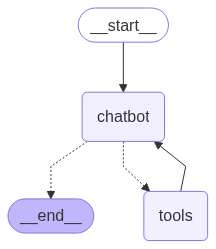

In [124]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [125]:
agent_executor = AgentExecutor(
    agent=agent,
    tools=toolbox,
    verbose=True,
    handle_parsing_errors=True,
    memory=memory,
)

### CSV Dataset Test Queries
(These will invoke the CSV retrieval + creation tools like create_new_record, hybrid similarity, etc.)

1. **Search CSV records:**

- "Find patients over 65 with high blood pressure from the dataset."

- "Show me the top 3 transactions with the highest total amount from the uploaded finance file."

2. **Insert a new CSV record:**

- "Add this row to the diabetes dataset: age: 50, bmi: 29.2, glucose: 130, outcome: 1."

- "Create a new customer record with name: John Doe, purchase: $450, product: smartwatch."

3. **Explain or compare CSV content:**

- "What does the glucose column represent in the diabetes file?"

- "Compare two entries with different 'outcome' values and explain the difference."

4. **Summarize CSV dataset:**

- "How many rows and columns are in the dataset 'diabetes_data.csv'?"

- "What types of values are in each column of 'hospital_admissions.csv'?"


### PDF Article Page Summary Queries
(These should use article_page_vector_search_tool with text-based embedding search on pages.)

1. **Textual search inside PDF pages:**

- "What does the article on 'Extreme Learning Machines' say about classification accuracy?"

- "Find pages discussing neural networks for diabetes prediction."

- "Show me summaries of PDF pages that mention performance benchmarks."

2. **Explain results and source:**

- "Which paper and page mention using support vector machines for feature selection?"

- "From which page is this quote taken: 'The training speed of ELM is very fast'?"

3. **Cross-modal reference:**

- "Is there any overlap between the CSV dataset and the concepts in the 'Early_Stage_Diabetes_Prediction' paper?"

### Image-Based PDF Search Queries (CLIP Embeddings)
(These activate vector_search_image_tool, searching using image bytes.)

1. **Search by image:**

- "Find pages with diagrams similar to this [upload chart or graph image]."

- "I have this image of a medical flowchart — which papers contain something similar?"

2. **Understand visual layout:**

- "Which PDF pages contain large tables or heatmaps?"

- "Upload this chart and tell me which article and page it's from."

3. **Cross-validation:**

- "Does this image match any pages in the article titled 'Early_Stage_Diabetes_Prediction_via_Extreme_Learning_Machine'?"

- "Show the summary of the page that matches this image."

### Multimodal Cross-Checks & Edge Cases
1. **Join CSV and PDF insights:**

- "Compare the patient outcomes in the CSV file with the results discussed in the ELM paper."

- "Is there a correlation between the glucose levels in the CSV and findings in any PDF pages?"

2. **Cache check validation (Gemini summaries):**

- "Summarize the first page of the PDF titled 'Early_Stage_Diabetes_Prediction_via_Extreme_Learning_Machine'."

- "Is there a Gemini-generated summary for page 3 of the diabetes prediction paper?"



In [126]:
def get_image_from_gcs(gcs_bucket, key: str) -> bytes:
    """
    Download image bytes from GCS.

    Args:
        gcs_bucket: GCS bucket instance.
        key (str): Blob key in the bucket.

    Returns:
        bytes: Image bytes.
    """
    blob = gcs_bucket.blob(key)
    return blob.download_as_bytes()

“”
Find articles showing visual evidence of pancreas damage in diabetes.
“Summarize full papers mentioning HbA1c monitoring.”

In [103]:
agent_executor.invoke(
    {
        "input": "Get me a list of research papers on the topic Machine Learning Methods on the treatment of Diabetes."
    }
)



> Entering new AgentExecutor chain...

Invoking: `article_page_vector_search_tool` with `{'query': 'Machine Learning Methods on the treatment of Diabetes'}`


[Machine_Learning_Approaches_for_Type_2_Diabetes_Prediction_and_Care_Management, Page 197]: ```json
{
  "summary": "This paper provides an overview of problem settings for diabetes prediction and care management, including a literature survey of various problems related to both. It emphasizes the importance of considering disease management when making predictions. The paper details problem descriptions, feature sets, and experimental results for predicting diabetes complications, model calibration, optimization methods, baselines, model evaluation, and model results. The authors hope these results will serve as a foundation for future machine learning research in diabetes.",
  "mentions": [
    "diabetes prediction",
    "diabetes care management",
    "prediction of diabetes complications",
    "model calibration",
    "optim

{'input': 'Get me a list of research papers on the topic Machine Learning Methods on the treatment of Diabetes.',
 'chat_history': "Human: Find similar records to this one: Age: 45, Gender: Male, Polyuria: Yes\nAI: The search results returned records from the dataset with `dataset_id`: `685052b612c7b37a8d059b93`.\n\nThe records share some similarities with your input, but the columns are different. The dataset contains information about diabetes patients, with columns like 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', and 'Outcome'.\n\nThe records retrieved have ages close to 45 (37, 47, 53, 63, 37). However, the search was based on semantic similarity, as the dataset does not contain 'Gender' or 'Polyuria' columns.\n\nHuman: Get me a list of research papers on the topic Machine Learning Methods on the treatment of Diabetes.\nAI: Here are some research papers that discuss machine learning methods for the treatment of di

In [128]:
agent_executor.invoke(
    {
        "input": "Find articles showing visuals of Correlation Between Diabetes and Related Chronic Conditions."
    }
)



> Entering new AgentExecutor chain...

Invoking: `article_page_vector_search_tool` with `{'model': 'clip', 'query': 'Correlation Between Diabetes and Related Chronic Conditions'}`


[Determination_of_personalized_diabetes_treatment_plans_using_a_two-delay_model, Page 7]: ```json
{
  "summary": "This section discusses a mathematical model for blood glucose regulation, focusing on Type II diabetes. It uses an eigenvalue equation to analyze the stability of blood glucose oscillations. The model incorporates parameters such as insulin sensitivity (γ), pancreatic efficiency (β), and glucose uptake efficiency (κ). The analysis aims to identify parameter values that result in healthy blood glucose profiles, characterized by stable oscillations within a moderate range (80-120 mg/dl). The section also explores how changes in β and γ affect the eigenvalues and, consequently, the stability of glucose oscillations.",
  "mentions": [
    "Type II diabetes",
    "eigenvalue equation",
    "insulin

{'input': 'Find articles showing visuals of Correlation Between Diabetes and Related Chronic Conditions.',
 'chat_history': 'Human: Find similar records to this one: Age: 45, Gender: Male, Polyuria: Yes\nAI: The search results returned records from the dataset with `dataset_id`: `685052b612c7b37a8d059b93`.\n\nThe records share some similarities with your input, but the columns are different. The dataset contains information about diabetes patients, with columns like \'Pregnancies\', \'Glucose\', \'BloodPressure\', \'SkinThickness\', \'Insulin\', \'BMI\', \'DiabetesPedigreeFunction\', \'Age\', and \'Outcome\'.\n\nThe records retrieved have ages close to 45 (37, 47, 53, 63, 37). However, the search was based on semantic similarity, as the dataset does not contain \'Gender\' or \'Polyuria\' columns.\n\nHuman: Get me a list of research papers on the topic Machine Learning Methods on the treatment of Diabetes.\nAI: Here are some research papers that discuss machine learning methods for the 

In [80]:
agent_executor.invoke({"input": "Find similar records to this one: Age: 45, Gender: Male, Polyuria: Yes"})



> Entering new AgentExecutor chain...

Invoking: `csv_files_vector_search_tool` with `{'query': 'Age: 45, Gender: Male, Polyuria: Yes'}`


[(Document(id='685056e712c7b37a8d059cdb', metadata={'_id': '685056e712c7b37a8d059cdb', 'Pregnancies': 10, 'Glucose': 179, 'BloodPressure': 70, 'SkinThickness': 0, 'Insulin': 0, 'BMI': 35.1, 'DiabetesPedigreeFunction': 0.2, 'Age': 37, 'Outcome': 0, 'dataset_id': '685052b612c7b37a8d059b93'}, page_content='Pregnancies: 10.0 Glucose: 179.0 Bloodpressure: 70.0 Skinthickness: 0.0 Insulin: 0.0 Bmi: 35.1 Diabetespedigreefunction: 0.2 Age: 37.0 Outcome: 0.0'), 0.9143085479736328), (Document(id='685056e712c7b37a8d059c46', metadata={'_id': '685056e712c7b37a8d059c46', 'Pregnancies': 5, 'Glucose': 143, 'BloodPressure': 78, 'SkinThickness': 0, 'Insulin': 0, 'BMI': 45.0, 'DiabetesPedigreeFunction': 0.19, 'Age': 47, 'Outcome': 0, 'dataset_id': '685052b612c7b37a8d059b93'}, page_content='Pregnancies: 5.0 Glucose: 143.0 Bloodpressure: 78.0 Skinthickness: 0.0 Insulin

{'input': 'Find similar records to this one: Age: 45, Gender: Male, Polyuria: Yes',
 'chat_history': '',
 'output': "The search results returned records from the dataset with `dataset_id`: `685052b612c7b37a8d059b93`.\n\nThe records share some similarities with your input, but the columns are different. The dataset contains information about diabetes patients, with columns like 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', and 'Outcome'.\n\nThe records retrieved have ages close to 45 (37, 47, 53, 63, 37). However, the search was based on semantic similarity, as the dataset does not contain 'Gender' or 'Polyuria' columns.\n"}

In [58]:
import re


def sanitize_name(name: str) -> str:
    """Sanitize the name to match the pattern '^[a-zA-Z0-9_-]+$'."""
    return re.sub(r"[^a-zA-Z0-9_-]", "_", name)

In [59]:
import asyncio
import warnings

from langchain_core.messages import HumanMessage,AIMessage, ToolMessage


async def chat_loop():
    config = {"configurable": {"thread_id": "0"}}

    while True:
        user_input = await asyncio.get_event_loop().run_in_executor(
            None, input, "User: "
        )
        user_input = user_input.strip()

        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        if not user_input:
            print("⚠️  Empty input skipped.")
            continue

        sanitized_name = (
            sanitize_name("Human") or "Anonymous"
        )  # Fallback if sanitized name is empty
        state = {"messages": [HumanMessage(content=user_input, name=sanitized_name)]}

        print("Assistant: ", end="", flush=True)

        max_retries = 3
        retry_delay = 1

        for attempt in range(max_retries):
            try:
                async for chunk in graph.astream(state, config, stream_mode="values"):
                    if chunk.get("messages"):
                        last_message = chunk["messages"][-1]
                        if isinstance(last_message, AIMessage):
                            last_message.name = (
                                sanitize_name(last_message.name or "AI") or "AI"
                            )
                            print(last_message.content, end="", flush=True)
                    elif isinstance(last_message, ToolMessage):
                        print(f"\n[Tool Used: {last_message.name}]")
                        print(f"Tool Call ID: {last_message.tool_call_id}")
                        print(f"Content: {last_message.content}")
                        print("Assistant: ", end="", flush=True)
                break
            except Exception as e:
                print(f"\n❌ Error: {e}")
                if attempt < max_retries - 1:
                    print(f"\nRetrying in {retry_delay} seconds...")
                    await asyncio.sleep(retry_delay)
                    retry_delay *= 2
                else:
                    print("⛔ Max retries reached. Exiting this turn.")

        print("\n")  # New line after the complete response

In [61]:
asyncio.run(chat_loop())

⚠️  Empty input skipped.
Goodbye!


In [65]:
import asyncio
import ipywidgets as widgets
from IPython.display import display, clear_output

from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

# Replace this with your actual sanitize_name and graph definitions
def sanitize_name(name):
    return name.strip()

# Dummy placeholder for graph.astream
async def dummy_astream(state, config, stream_mode):
    # Simulate streaming response chunks
    yield {"messages": [AIMessage(content="Hello, how can I help you?")]}
    await asyncio.sleep(0.5)
    yield {"messages": [AIMessage(content=" Here's the answer to your question.")]}
    await asyncio.sleep(0.5)

graph = type("Graph", (), {"astream": dummy_astream})

# Widgets for user input and output
input_box = widgets.Text(placeholder="Type your message here...")
send_button = widgets.Button(description="Send")
output_area = widgets.Output(layout={'border': '1px solid black', 'height': '300px', 'overflow_y': 'auto'})

config = {"configurable": {"thread_id": "0"}}

async def handle_user_input(user_input):
    sanitized_name = sanitize_name("Human") or "Anonymous"
    state = {"messages": [HumanMessage(content=user_input, name=sanitized_name)]}

    async def run_chat():
        try:
            async for chunk in graph.astream(state, config, stream_mode="values"):
                if chunk.get("messages"):
                    last_message = chunk["messages"][-1]
                    if isinstance(last_message, AIMessage):
                        last_message.name = sanitize_name(last_message.name or "AI") or "AI"
                        with output_area:
                            print(f"{last_message.name}: {last_message.content}", end="", flush=True)
                    elif isinstance(last_message, ToolMessage):
                        with output_area:
                            print(f"\n[Tool Used: {last_message.name}]")
                            print(f"Tool Call ID: {last_message.tool_call_id}")
                            print(f"Content: {last_message.content}")
                            print("Assistant: ", end="", flush=True)
        except Exception as e:
            with output_area:
                print(f"\n❌ Error: {e}")

    await run_chat()
    with output_area:
        print("\n")  # new line after complete response

def on_send_button_clicked(b):
    user_input = input_box.value.strip()
    if not user_input:
        with output_area:
            print("⚠️ Empty input skipped.\n")
        return
    if user_input.lower() in ["quit", "exit", "q"]:
        with output_area:
            print("Goodbye!")
        input_box.disabled = True
        send_button.disabled = True
        return

    with output_area:
        print(f"User: {user_input}")

    input_box.value = ""

    # Run async chat in background
    asyncio.create_task(handle_user_input(user_input))

send_button.on_click(on_send_button_clicked)

# Display widgets
display(input_box, send_button, output_area)


Text(value='', placeholder='Type your message here...')

Button(description='Send', style=ButtonStyle())

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

 Example Use Cases for This Agent
- “Find similar records to this one: Age: 45, Gender: Male, Polyuria: Yes”

- “Create a new record for dataset X with these values...”

- “Which datasets have columns related to diabetes symptoms?”

- “Compare a record from dataset A with a similar one from dataset B”



In [60]:
# For Jupyter notebooks and IPython environments
import nest_asyncio

nest_asyncio.apply()

# Run the async function
await chat_loop()

Assistant: 

/Users/tubakaraca/.pyenv/versions/3.12.0/lib/python3.12/site-packages/langchain_google_genai/chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(
/var/folders/jt/f12_3w995dg5jn6dh4r5vvxm0000gn/T/ipykernel_50477/1548652449.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
/Users/tubakaraca/.pyenv/versions/3.12.0/lib/python3.12/site-packages/langchain_google_genai/chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


The search query "Age: 45, Gender: Male, Polyuria: Yes" returned the following records:

CSV Record Summary:
- Dataset: 685052b612c7b37a8d059b93 (ID: 685056e712c7b37a8d059cdb)
- Columns: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome, dataset_id
- Record:
      Pregnancies: 10.0
      Glucose: 179.0
      BloodPressure: 70.0
      SkinThickness: 0.0
      Insulin: 0.0
      BMI: 35.1
      DiabetesPedigreeFunction: 0.2
      Age: 37.0
      Outcome: 0.0
- Notes: The age is different (37 vs 45) and the columns don't include Gender or Polyuria.

CSV Record Summary:
- Dataset: 685052b612c7b37a8d059b93 (ID: 685056e712c7b37a8d059c46)
- Columns: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome, dataset_id
- Record:
      Pregnancies: 5.0
      Glucose: 143.0
      BloodPressure: 78.0
      SkinThickness: 0.0
      Insulin: 0.0
      BMI: 45.0
      DiabetesPedigreeFunction: 0.19


/var/folders/jt/f12_3w995dg5jn6dh4r5vvxm0000gn/T/ipykernel_50477/1548652449.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)




Assistant: 

/Users/tubakaraca/.pyenv/versions/3.12.0/lib/python3.12/site-packages/langchain_google_genai/chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(
/var/folders/jt/f12_3w995dg5jn6dh4r5vvxm0000gn/T/ipykernel_50477/1548652449.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
/var/folders/jt/f12_3w995dg5jn6dh4r5vvxm0000gn/T/ipykernel_50477/1009492521.py:22: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  hybrid_search_result = hybrid_search.get_relevant_documents(query)
/Users/tubakaraca/.pyenv/versions/3.12.0/lib/python3.12/site-packages/langchain_google_gena

The dataset with ID '685052b612c7b37a8d059b93' appears to have columns related to diabetes, specifically 'Glucose', but does not have columns for the other symptoms mentioned (polyuria, polydipsia, weight loss, fatigue, blurred vision, slow healing, frequent infections).

Assistant: 

/Users/tubakaraca/.pyenv/versions/3.12.0/lib/python3.12/site-packages/langchain_google_genai/chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


Please provide the IDs of the two records you would like me to compare.

/var/folders/jt/f12_3w995dg5jn6dh4r5vvxm0000gn/T/ipykernel_50477/1548652449.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)




Assistant: 

/Users/tubakaraca/.pyenv/versions/3.12.0/lib/python3.12/site-packages/langchain_google_genai/chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


The ID '685052b612c7b37a8d059b93' is a dataset ID, not a record ID. The ID '685056e712c7b37a8d059cdb' is a record ID. Please provide two record IDs to compare.

/var/folders/jt/f12_3w995dg5jn6dh4r5vvxm0000gn/T/ipykernel_50477/1548652449.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)




Assistant: 

/Users/tubakaraca/.pyenv/versions/3.12.0/lib/python3.12/site-packages/langchain_google_genai/chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(
/var/folders/jt/f12_3w995dg5jn6dh4r5vvxm0000gn/T/ipykernel_50477/1548652449.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
/Users/tubakaraca/.pyenv/versions/3.12.0/lib/python3.12/site-packages/langchain_google_genai/chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


CSV Record Summary:
- Dataset: 685000ea12c7b37a8d058b9c (ID: 6850214d12c7b37a8d058d02)
- Columns: Diabetes_Status, Age, B_cells_pct_of_Lymphocytes, Transitional_pct_of_B_cells, Naive_pct_of_B_cells, Nonnegclassnegswitched_Memory_pct_of_B_cells, Classnegswitched_Memory_pct_of_B_cells, _7, MNC_pct_of_Leukocytes, Granulocyte_pct_of_Leukocytes, DC_pct_of_MNCs, HLAnegDR_mfi_of_DCs, Myeloid_pct_of_DCs, Plasmacytoid_pct_DCs, CD11cnegCD123neg_pct_of_DC, Monocytes_pct_of_MNCs, HLAnegDR_mfi_of_Monocytes, Classical_pct_of_Monocytes, NonnegClassical_pct_of_Monocytes, NK_pct_of_Lymphocytes, CD56bright_pct_of_NK, CD56dim_pct_of_NK, CD16pos_pct_of_CD56bright_NK, CD123pos_pct_of_MNCs, T_cells_pct_of_Lymphocytes, CD4_pct_of_T_cells, CD38negHLADRneg_pct_of_CD4, CD38negHLADRpos_pct_of_CD4, CD38posHLADRneg_pct_of_CD4, CD38posHLADRpos_pct_of_CD4, Naive_pct_of_CD4, CD38negHLADRneg_pct_of_Naive_CD4, CD38negHLADRpos_pct_of_Naive_CD4, CD38posHLADRneg_pct_of_Naive_CD4, CD38posHLADRpos_pct_of_Naive_CD4, Tem_pct_

/var/folders/jt/f12_3w995dg5jn6dh4r5vvxm0000gn/T/ipykernel_50477/1548652449.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)




⚠️  Empty input skipped.
⚠️  Empty input skipped.
⚠️  Empty input skipped.
⚠️  Empty input skipped.
Goodbye!
